# Import
Import aller wichtigen Libraries und Dateien.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import plot_tree
from sklearn.model_selection import validation_curve

df_train = pd.read_csv("dataset/dengue_features_train.csv")
df_labels = pd.read_csv("dataset/dengue_labels_train.csv")

# Teilung durch Geographie
Die Datensätze werden anhand der Stadt (sj für San Juan und iq für Iquitos) aufgeteilt. Man sieht später in der Analyse, dass sich beide Städte stark unterscheiden.

In [3]:
# Aufteilung in Trainingsdaten (_train) und Validierungsdaten (_labels)
df_sj_train = df_train.loc[df_train['city']=='sj']
df_sj_labels = df_labels.loc[df_labels['city']=='sj']

df_iq_train = df_train.loc[df_train['city']=='iq']
df_iq_labels = df_labels.loc[df_labels['city']==('iq')]

# Spalten, die in der weiteren Verarbeitung als nicht ausschlaggebend betrachtet werden
ignore_cols = ['city','year', 'weekofyear', 'week_start_date']
df_sj_ignored = df_sj_train.drop(columns=ignore_cols)
df_iq_ignored = df_iq_train.drop(columns=ignore_cols)

# Beschreibung der Attribute

### NDVI-Daten
Spanne von -1 bis 1.
Sagt Vegetation aus.
<0 steht für Wasser, Wolken
zwischen 0 und 0.1 steht für barrer Boden
zwischen 0.1 und 0.5 steht für karge Vegetation
\>0.5 steht für enge, grüne Vegetation
* ndvi_ne: im nordöstlichen Quadrant
* ndvi_nw: im nordwestlichen Quadrant
* ndvi_se: im südöstlichen Quadrant
* ndvi_sw: im südwestlichen Quadrant

### NCEP Klima-Vorhersage System Reanalyse
| Attribut                              | Maßeinheit                          | Beschreibung                               |
|---------------------------------------|-------------------------------------|--------------------------------------------|
| reanalysis_sat_precip_amt_mm          | Millimeter                          | Insgesamter Niederschlag                   |
| reanalysis_dew_point_temp_k           | °Kelvin                             | durchschnittliche Tautemperatur            |
| reanalysis_air_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_relative_humidity_percen   | Prozent                             | Durchschnittliche relative Feuchtigkeit    |
| reanalysis_specific_humidity_g_per_kg | Gramm (Wasser) pro Kilogramm (Luft) | Durchschnittliche spezifische Feuchtigkeit |
| reanalysis_precip_amt_kg_per_m2       | Kilogramm pro Quadratmeter          | Insgesamter Niederschlag                   |
| reanalysis_max_air_temp_k             | °Kelvin                             | Maximale Lufttemperatur                    |
| reanalysis_min_air_temp_k             | °Kelvin                             | Minimale Lufttemperatur                    |
| reanalysis_avg_temp_k                 | °Kelvin                             | Durchschnittliche Lufttemperatur           |
| reanalysis_tdtr_k                     | °Kelvin                             | Tägliche Temperaturspanne                  |

### PERSIANN Niederschlagsdaten vom Satellit
* precipitation_amt_mm: Insgesamter Niederschlag in Millimeter

### GHCN Tägliche Klimadaten
| Attribut                | Maßeinheit | Beschreibung              |
|-------------------------|------------|---------------------------|
| station_max_temp_c      | °Celsius   | Maximale Temperatur       |
| station_min_temp_c      | °Celsius   | Minimale Temperatur       |
| station_avg_temp_c      | °Celsius   | Durchschnittstemperatur   |
| station_precip_mm       | Millimeter | Insgesamter Niederschlag  |
| station_diur_temp_rng_c | °Celsius   | Tägliche Temperaturspanne |

# Datenvisualisierung
Die Daten werden visualisiert um erste Eindrücke zu erfassen und die Daten näher Betrachten zu können.
## Zeitreihendarstellung
Hier sieht man zunüchst alle Krankheitsfälle beider Städte im Gesamtzeitraum, um einen groben Überblick zu bekommen.
Der Datensatz von San Juan wurde in einem größeren Zeitraum aufgenommen als Iquitos. Außerdem gibt es mehr und volatilere Krankheitsfälle in San Juan als Iquitos. Aus diesem Grund müssen zwei Analysen und eventuell auch Modelle durchgeführt und aufgebaut werden. 

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\4008185393.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train['week_start_date'] = pd.to_datetime(df_sj_train['week_start_date'], format='%Y-%m-%d')
C:\Users\rener\AppData\Local\Temp\ipykernel_25824\4008185393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')


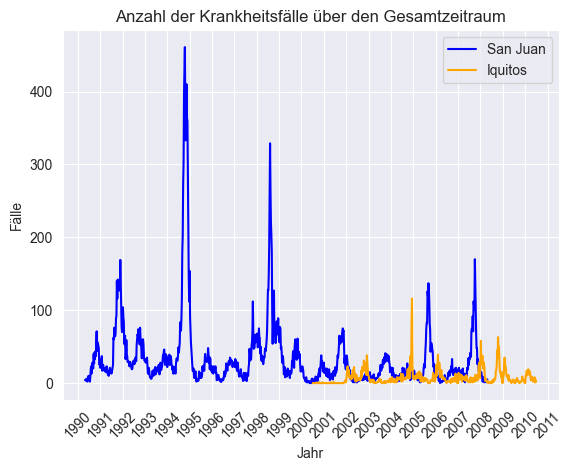

In [4]:
df_sj_train['week_start_date'] = pd.to_datetime(df_sj_train['week_start_date'], format='%Y-%m-%d')
df_iq_train['week_start_date'] = pd.to_datetime(df_iq_train['week_start_date'], format='%Y-%m-%d')

fig, ax = plt.subplots()

ax.plot(df_sj_train['week_start_date'], df_sj_labels['total_cases'], label='San Juan', color='blue')
ax.plot(df_iq_train['week_start_date'], df_iq_labels['total_cases'], label='Iquitos', color='orange')

ax.set_title('Anzahl der Krankheitsfälle über den Gesamtzeitraum')
ax.set_xlabel('Jahr')
ax.set_ylabel('Fälle')
ax.legend()

# Setzen Sie die Locator- und Formatter-Objekte für die x-Achse
ax.xaxis.set_major_locator(mdates.YearLocator(1))  # Locator für 1-Jahres-Schritte
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formatter für das Anzeigen des Jahres

plt.xticks(rotation=45)  # Optional: Drehen Sie die Jahreszahlen für eine bessere Lesbarkeit

plt.savefig('pictures/total_cases_im_gesamtzeitraum.png', bbox_inches="tight")
plt.show()

Im weiteren Verfahren werden zuerst die Daten aus San Juan bearbeitet und danach die von Iquitos.

## Fehlende Werte
Abgebildet ist die prozentuale Verteilung der fehlenden Einträgen pro Attribut. 

In [5]:
def missing_data_percent(df):
    # Verteilung der fehlenden Daten
    null_vals = df.isnull().sum()
    total_vals = len(df)
    null_percent = (null_vals / total_vals) * 100
    df_null_percent = pd.DataFrame({'Attribut': null_vals.index, 'Prozent': null_percent.values})
    barplot = sns.barplot(x='Attribut', y='Prozent', data=df_null_percent)
    barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.title('Prozentige Verteilung der fehlenden Daten pro Attribut | San Juan')
    plt.savefig('pictures/prozentverteilung_null_werte_sj.png',bbox_inches="tight")
    plt.show()

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\1660113403.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")


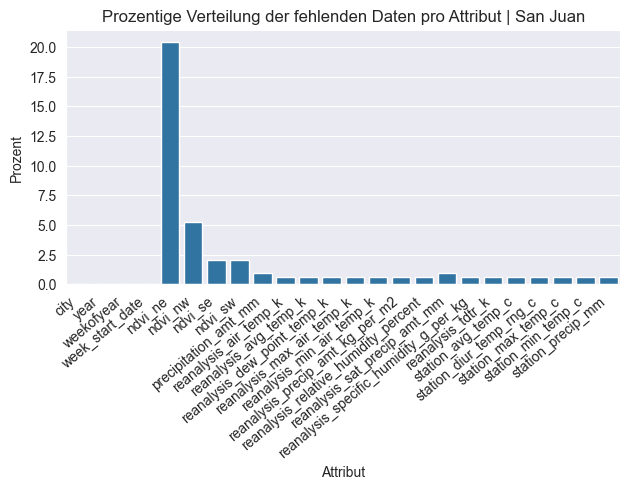

In [6]:
missing_data_percent(df_sj_train)

## Wertebereichverteilung
Ermittlung der Wertebereiche der Attribute. Die Attribute liegen in numerischer Form vor.

In [7]:
def max_min_avg(df):
    # Zeigt Minimum, Maximum und Durchschnitt der Attribute
    result_df = pd.DataFrame({
    'max': df_sj_ignored.max(),
    'min': df_sj_ignored.min(),
    'avg': df_sj_ignored.mean()
    })
    return result_df

In [8]:
max_min_avg(df_sj_ignored)

max         min         avg
ndvi_ne                                  0.493400   -0.406250    0.057925
ndvi_nw                                  0.437100   -0.456100    0.067469
ndvi_se                                  0.393129   -0.015533    0.177655
ndvi_sw                                  0.381420   -0.063457    0.165956
precipitation_amt_mm                   390.600000    0.000000   35.470809
reanalysis_air_temp_k                  302.200000  295.938571  299.163653
reanalysis_avg_temp_k                  302.164286  296.114286  299.276920
reanalysis_dew_point_temp_k            297.795714  289.642857  295.109519
reanalysis_max_air_temp_k              304.300000  297.800000  301.398817
reanalysis_min_air_temp_k              299.900000  292.600000  297.301828
reanalysis_precip_amt_kg_per_m2        570.500000    0.000000   30.465419
reanalysis_relative_humidity_percent    87.575714   66.735714   78.568181
reanalysis_sat_precip_amt_mm           390.600000    0.000000   35.470809
reanalysis_specific_humidity_g_per_kg   19.440000   11.715714   16.552409
reanalysis_tdtr_k                        4.428571    1.357143    2.516267
station_avg_temp_c                      30.071429   22.842857   27.006528
station_diur_temp_rng_c                  9.914286    4.528571    6.757373
station_max_temp_c                      35.600000   26.700000   31.607957
station_min_temp_c                      25.600000   17.800000   22.600645
station_precip_mm                      305.900000    0.000000   26.785484

In [9]:
def attribute_distribution_histogram(df,rows,cols):
    # Erstellt Histogramme der Attribute
    fig, axs = plt.subplots(rows, cols, figsize=(15, 15))
    axs = axs.flatten()
    for i, column in enumerate(df.columns):
        sns.histplot(data=df, x=column, kde=True, color="skyblue", ax=axs[i])
    plt.tight_layout()
    plt.show()

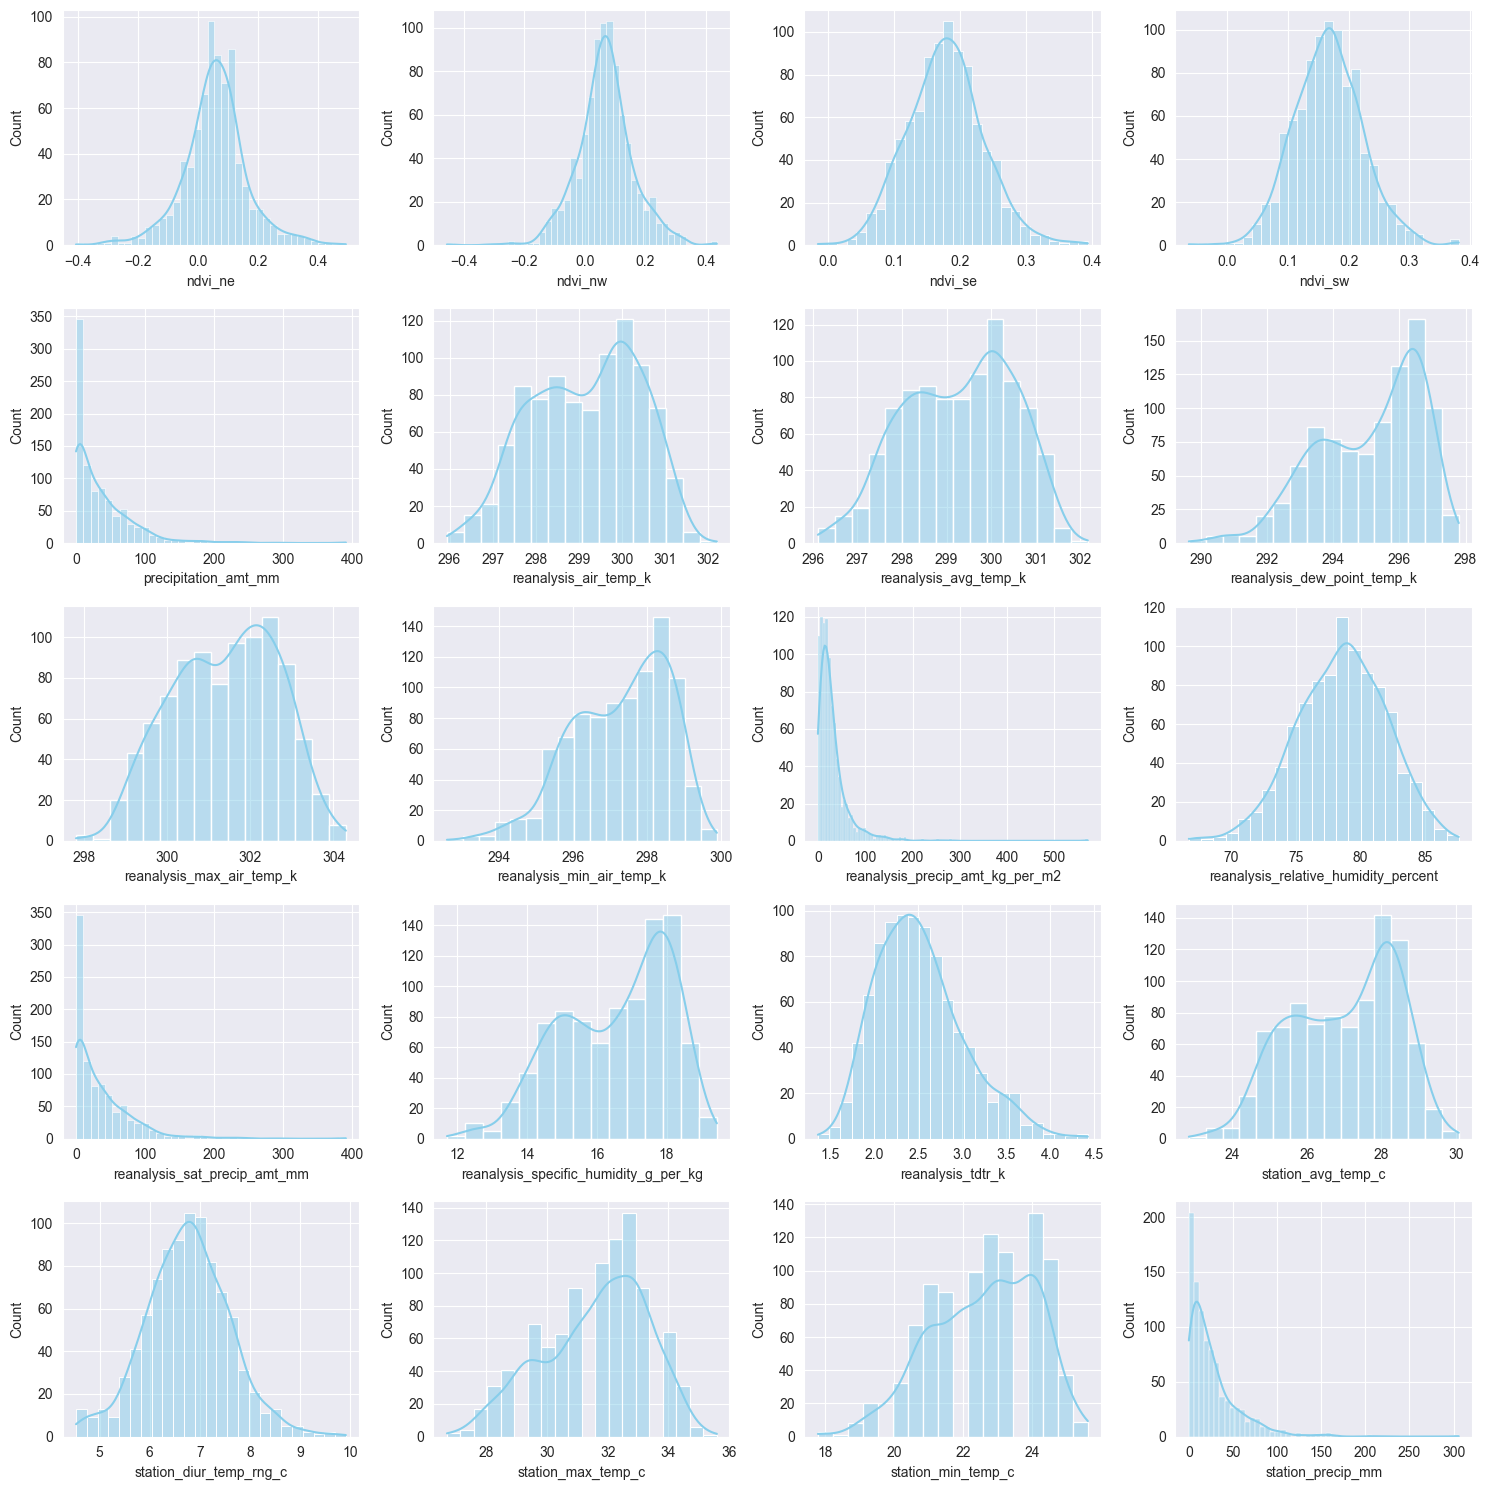

In [10]:
attribute_distribution_histogram(df_sj_ignored,5,4)

## Ausreißer
wenige Ausreißer bei temperaturbedingten Attributen
mäßige Ausreißer bei Vegetationsdaten
sehr viele Ausreißer bei Niederschlagsdaten

In [11]:
def outlier_boxplot(df):
    # Erstellt Boxplots für jedes Attribut
    num_columns = len(df.columns)
    num_rows = -(-num_columns // 4)
    fig, axes = plt.subplots(nrows=num_rows, ncols=4, figsize=(20, 5 * num_rows))
    axes = axes.flatten()
    for idx, column in enumerate(df.columns):
        sns.boxplot(y=df[column], ax=axes[idx])
        axes[idx].set_title(column)
    for i in range(num_columns, len(axes)):
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

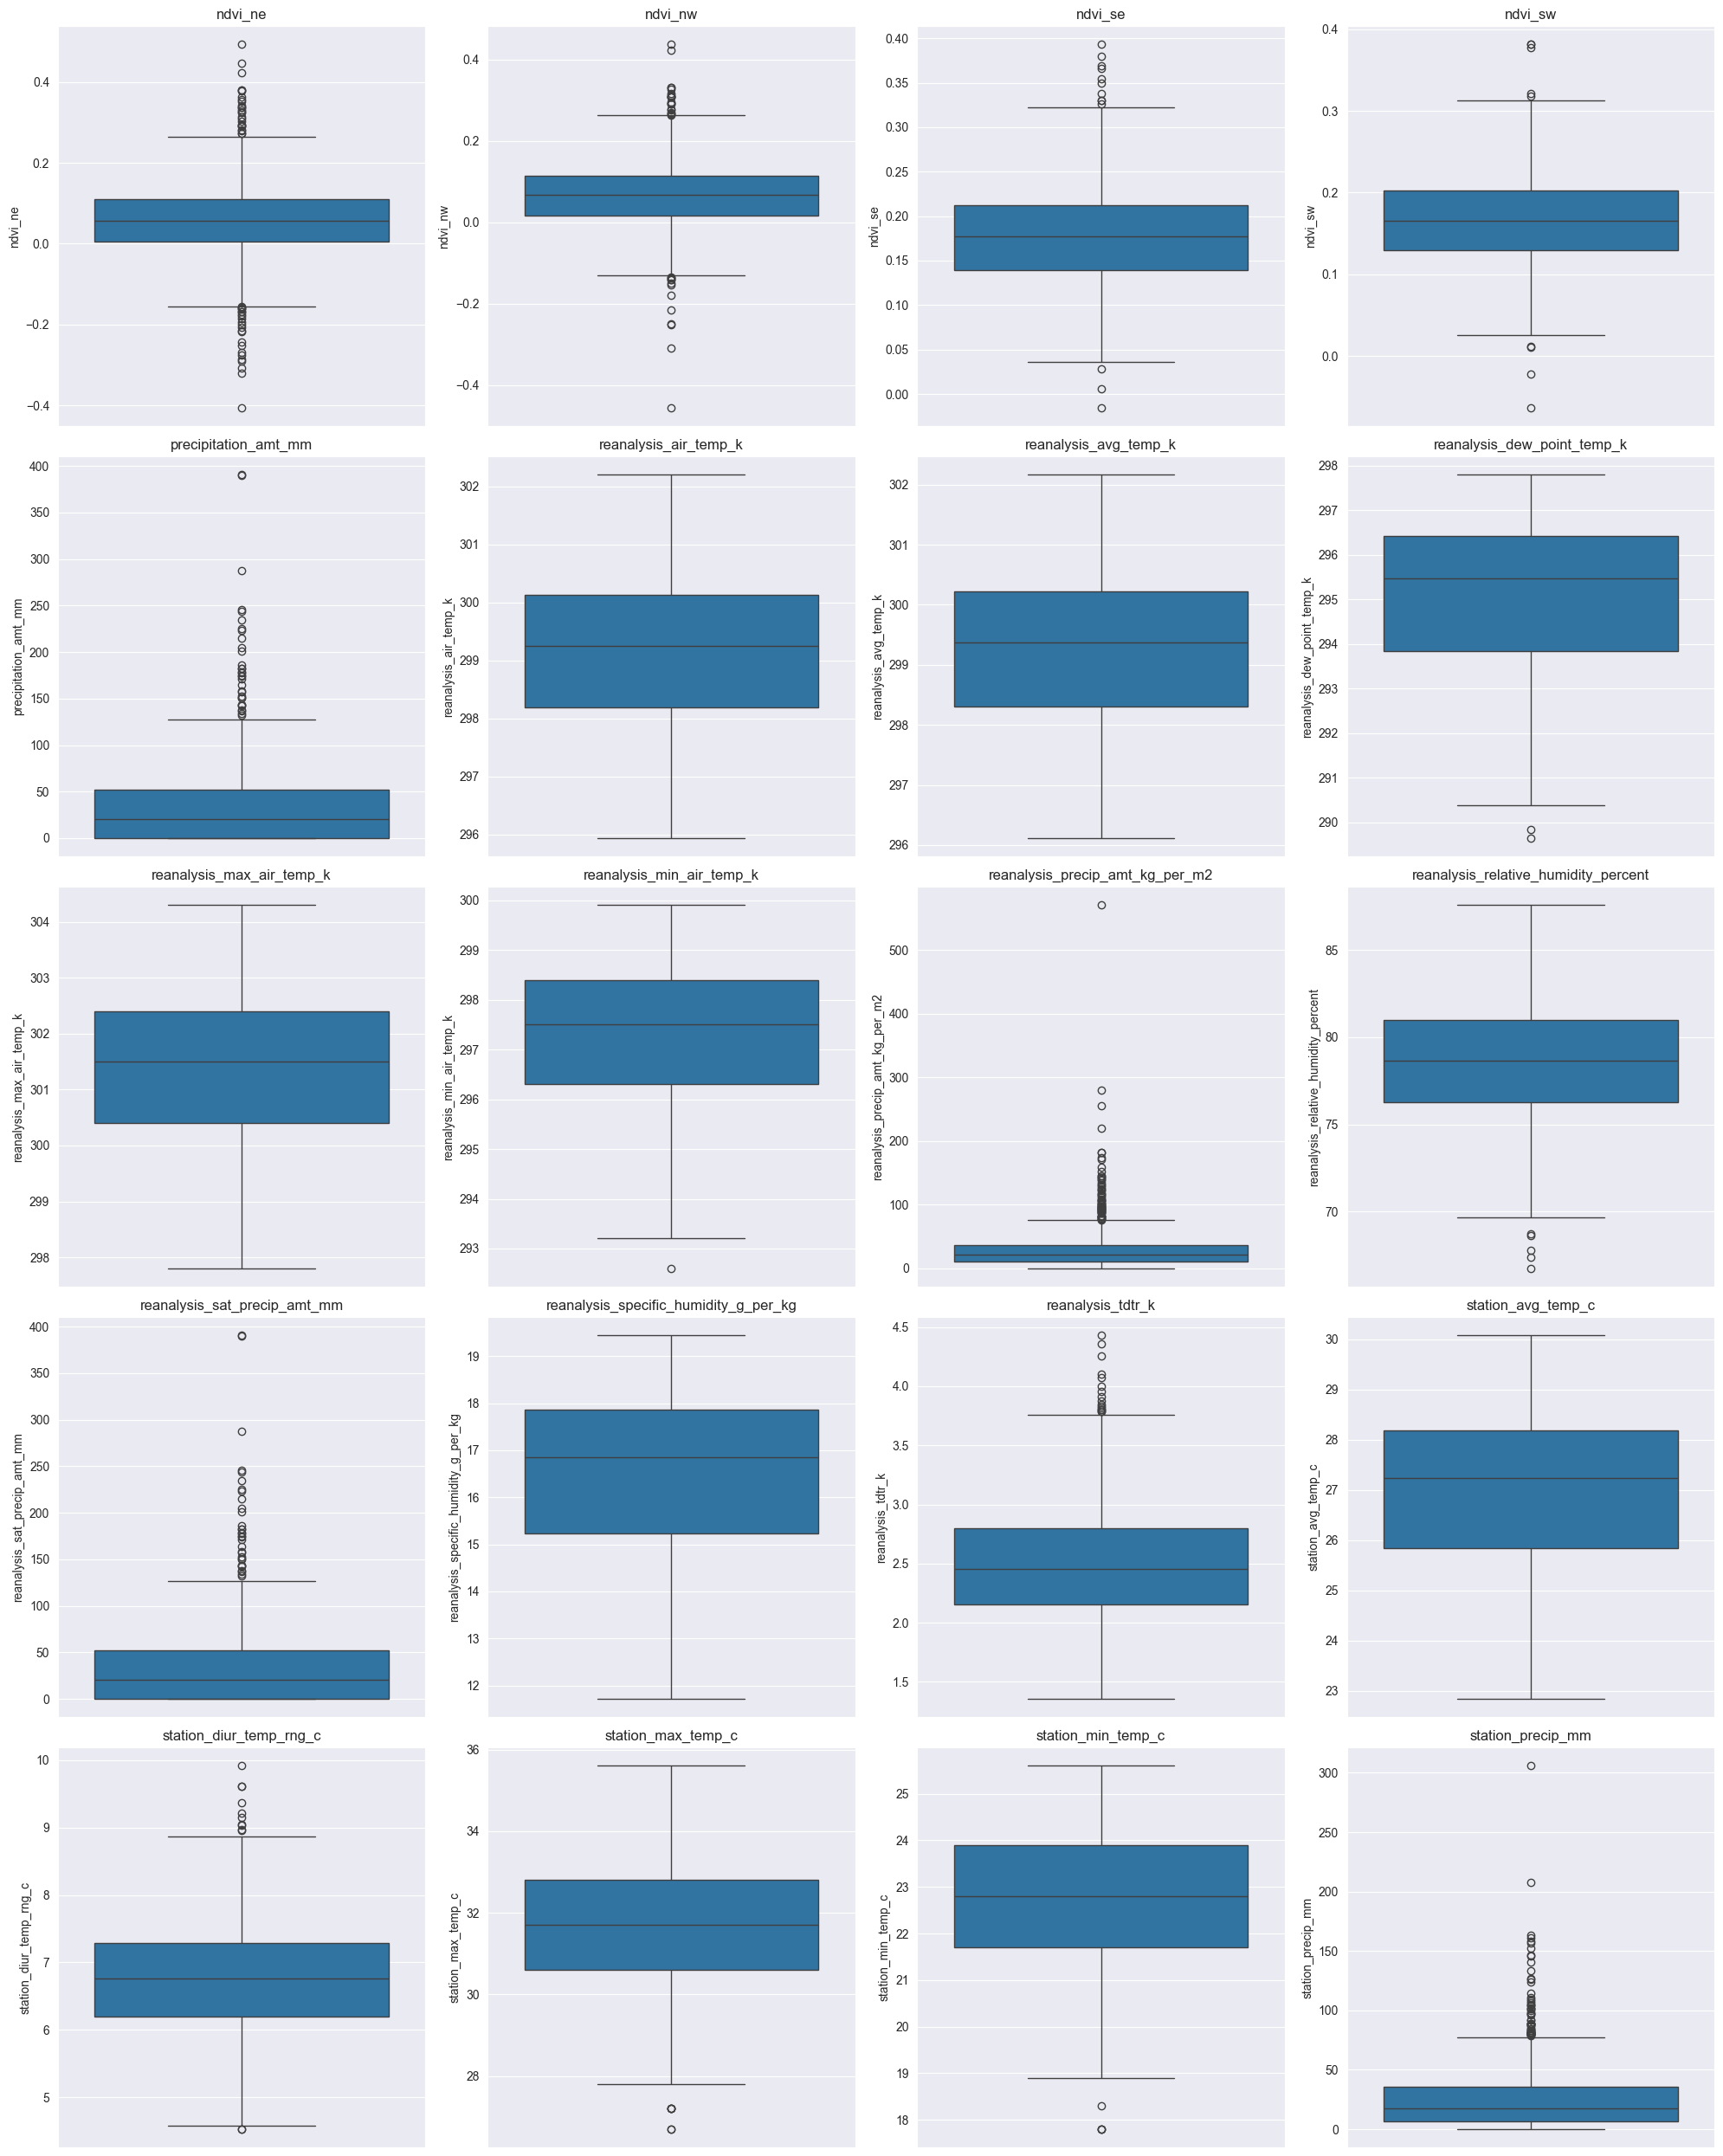

In [12]:
outlier_boxplot(df_sj_ignored)

## Korrelierende Daten
Damit ein besseres Verständnis erlangen werden kann, wie die Beziehung der Features zu der Zielvariable sind, wird der Korrelationskoeffizient eingesetzt. 

In [13]:
def correlation_matrix(df,df_goal,col_list,annotation):
    df_corr = df[col_list].copy()
    df_corr['total_cases'] = df_goal['total_cases'].copy()
    plt.figure(figsize=[10,10])
    sns.heatmap(df_corr.corr(numeric_only=True),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=annotation)
    plt.show()

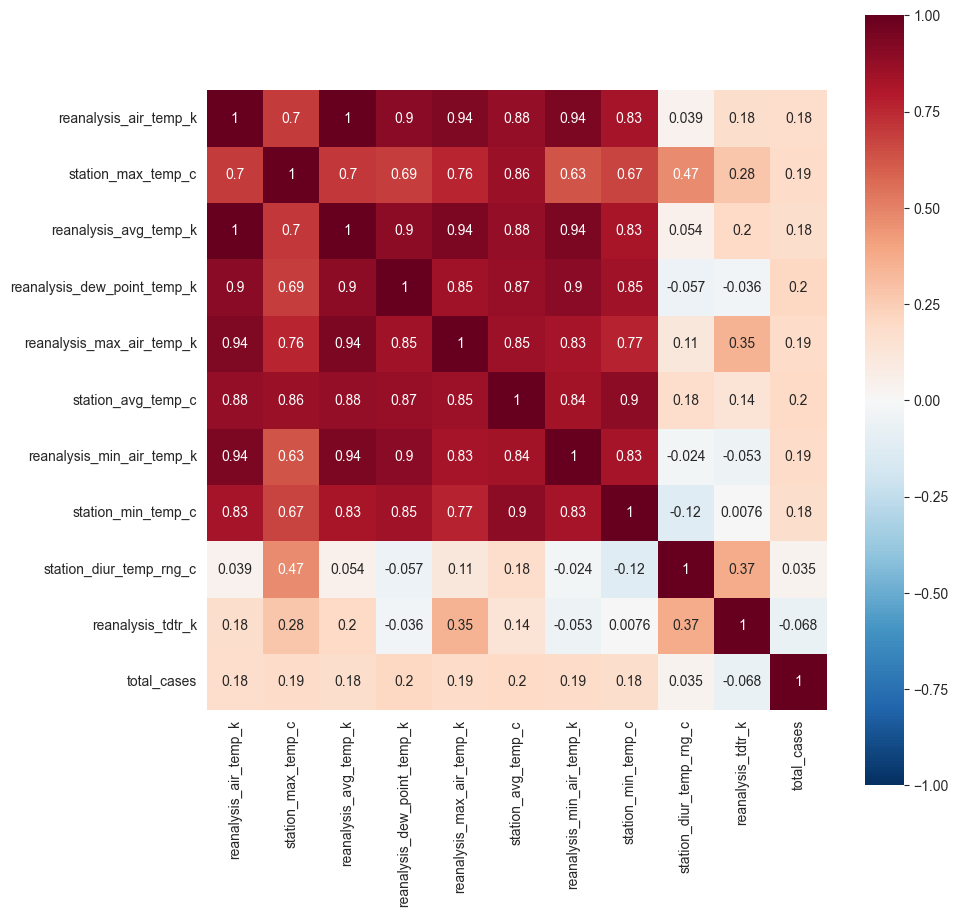

In [14]:
correlation_matrix(df_sj_train,df_sj_labels, ['reanalysis_air_temp_k',
                           'station_max_temp_c',
                           'reanalysis_avg_temp_k',
                           'reanalysis_dew_point_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'station_diur_temp_rng_c',
                           'reanalysis_tdtr_k',
                           ],True)

Die Korrelationsmatrix zeigt, dass die Attribute der Temperaturspannen ('station_diur_temp_rng_c','reanalysis_tdtr_k') nicht mit den Krankheitsfällen korrelieren und werden deswegen für die Weiterverarbeitung nicht benötigt
Weiterhin kann man sehen, dass alle restlichen temperaturbezogenen Attribute stark miteinander korrelieren. Demnach können sie normalisiert werden und mit dem gemeinsamen Durchschnitt zu einer Variable zusammengefasst werden. Eine Ausnahme ist hierbei 'station_max_temp_c', weil es nicht so stark mit den anderen Temperaturvariablen korreliert, aber dennoch mit der Zielvariable korreliert. Diese Variable kann ohne weiteres verwendet werden

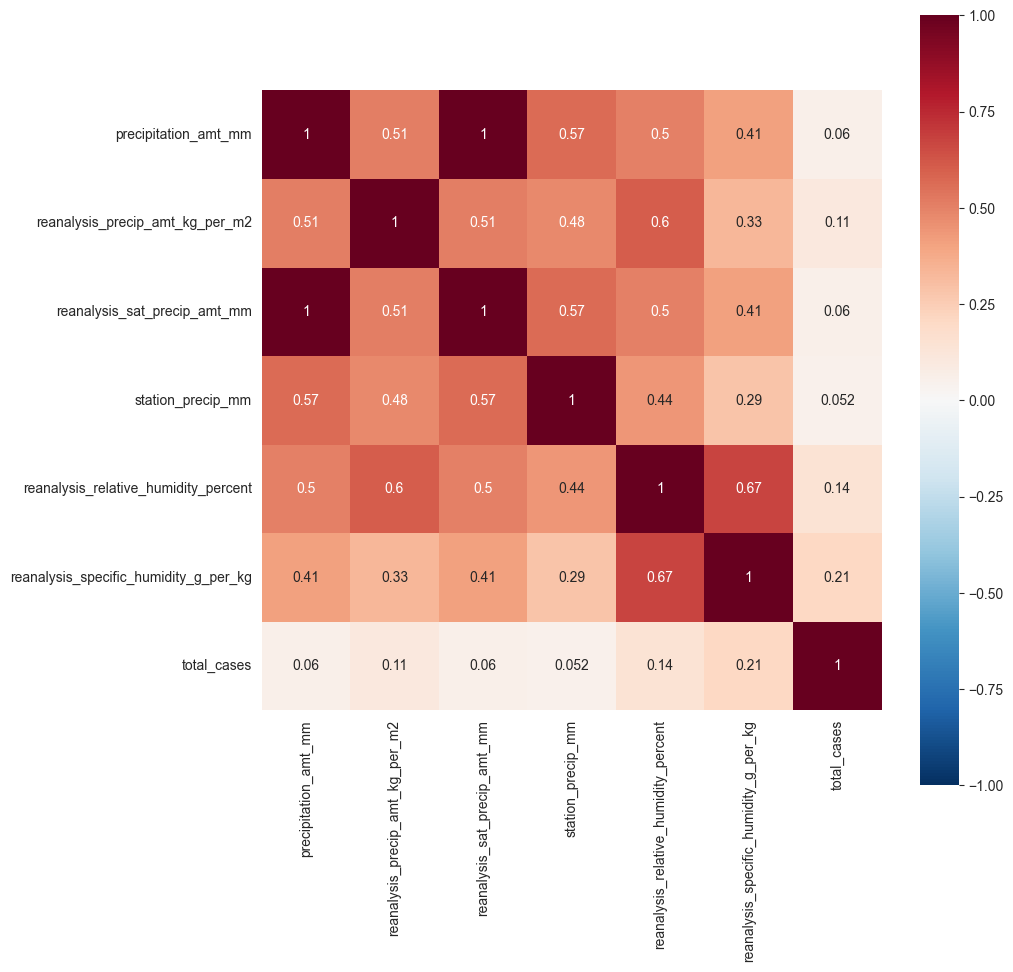

In [15]:
# Niederschlagsdaten
correlation_matrix(df_sj_train,df_sj_labels,['precipitation_amt_mm',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_sat_precip_amt_mm',
                             'station_precip_mm',
                             'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg'],True)

Zu erkennen ist, dass 'precipitation_amt_mm' und 'reanalysis_sat_precip_amt_mm' gleich sind. Dies wird durch einen Blick durch die Daten bestätigt.
Jedoch ist ihre Korrelation zu 'total_cases' sehr niedrig, was bedeutet, dass sie nicht geeignet sind.

In [16]:
df_sj_train[['precipitation_amt_mm', 'reanalysis_sat_precip_amt_mm']].head()

precipitation_amt_mm  reanalysis_sat_precip_amt_mm
0                 12.42                         12.42
1                 22.82                         22.82
2                 34.54                         34.54
3                 15.36                         15.36
4                  7.52                          7.52

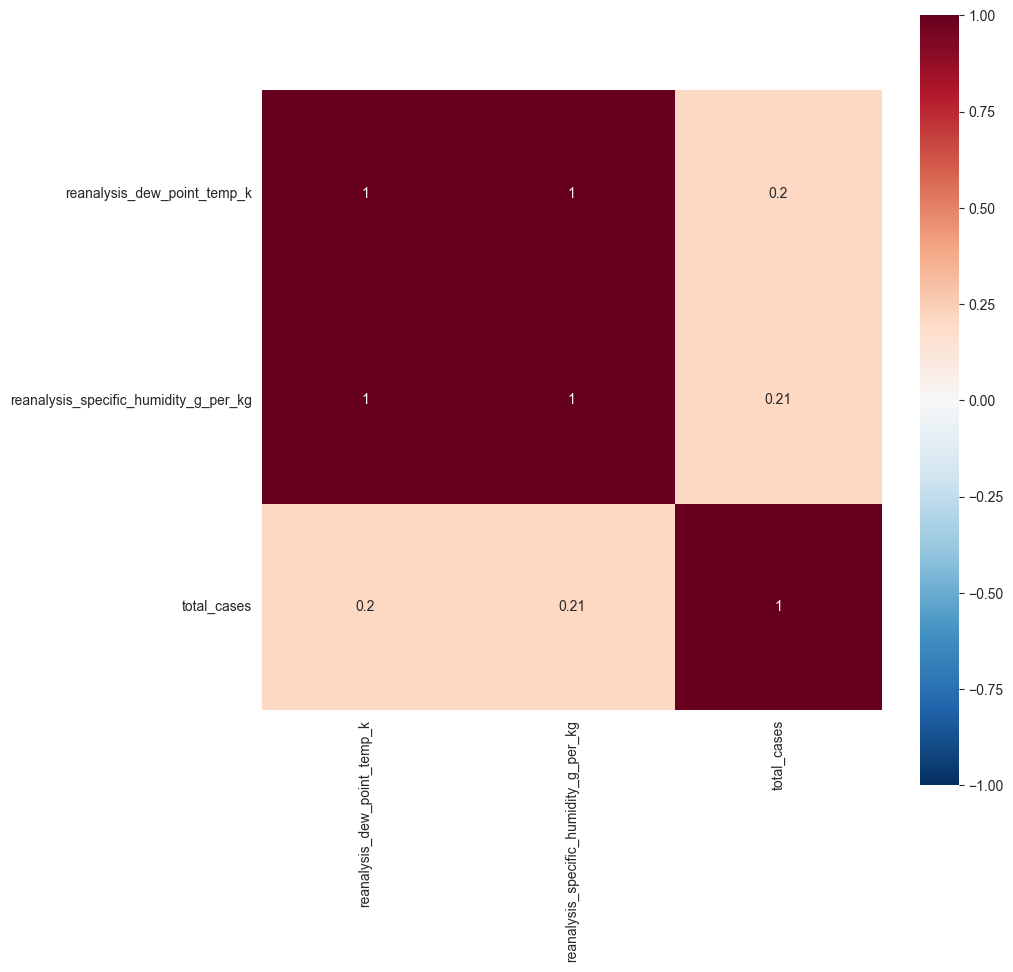

In [17]:

correlation_matrix(df_sj_train,df_sj_labels,['reanalysis_dew_point_temp_k',
                             'reanalysis_specific_humidity_g_per_kg'],True)

Die beiden Attribute korrelieren stark und haben auch ungefähr den gleichen Einfluss auf die Zielvariable. Sie können standardisiert und zusammengefasst werden

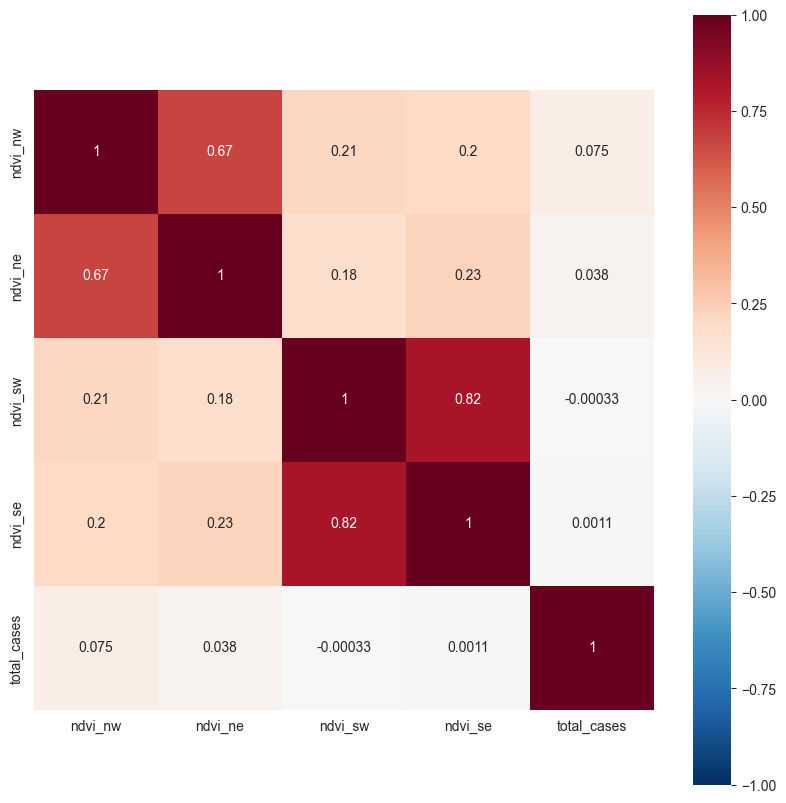

In [18]:
# Vegetationsdaten und Zielvariable
correlation_matrix(df_sj_train,df_sj_labels,['ndvi_nw','ndvi_ne','ndvi_sw','ndvi_se',],True)

Die Korrelationsmatrix zeigt, dass die Vegetationsdaten sehr wenig mit den Krankheitsfällen korrelieren.

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\3891561992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train['total_cases']=df_sj_labels['total_cases']
C:\Users\rener\AppData\Local\Temp\ipykernel_25824\3891561992.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sj_correlations = df_sj_train.corr()


<AxesSubplot: >

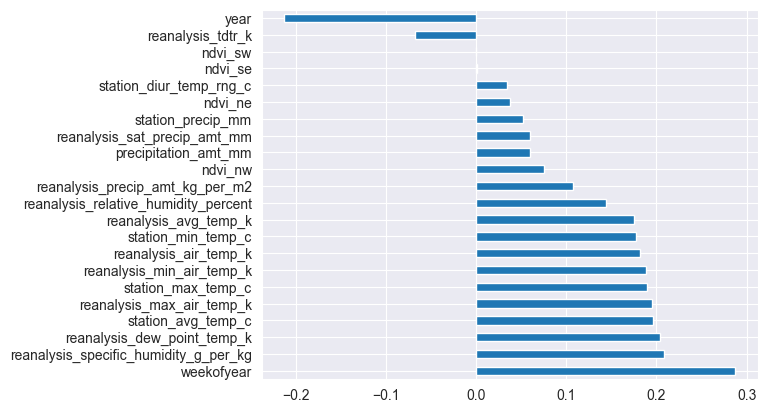

In [19]:
df_sj_train['total_cases']=df_sj_labels['total_cases']
sj_correlations = df_sj_train.corr()
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

# Datenpräparation
Im Schritt der Datenpräparation werden nun Variablen ausgewählt, bereinigt, imputiert oder transformiert, die für die Vorhersage relevant sind. Manche Variablen wurden schon durch den Visualisierungsprozess präpariert (z.B. "week_start_date") um besser mit ihnen umgehen zu können.

## Auswahl der Attribute
Ein DataFrame mit allen ausgewählten Variablen zur Erstellung des Models wird erstellt. Es wurden die Variablen ausgewählt, die einen Korrelationskoeffizienten von >0.1 besitzen.

In [20]:
df_sj_model_features = df_sj_train[['station_max_temp_c',
                                    'reanalysis_relative_humidity_percent',
                                    'reanalysis_precip_amt_kg_per_m2']].copy() 

## Normalisierung
Aus den Temperaturvariablen werden die Durchschnitte pro Woche ermittelt, woraus sich eine neue Variable "temp_avg" ergibt. Alle Variablen wurden normalisiert, um Skalendifferenzen zu vermeiden

In [21]:
def normalize_cols(df_in,df_out,cols,name):
    scaler = MinMaxScaler()
    df_temp = df_in[cols].copy()
    df_out[name] = pd.DataFrame(scaler.fit_transform(df_temp), columns=df_temp.columns).mean(axis=1).copy()

In [22]:
temp_cols = ['reanalysis_air_temp_k',
                           'reanalysis_avg_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'reanalysis_dew_point_temp_k']
normalize_cols(df_sj_train,df_sj_model_features,temp_cols,'temp_avg')

In [23]:
humid_cols = ['reanalysis_specific_humidity_g_per_kg']
normalize_cols(df_sj_train,df_sj_model_features,humid_cols,'norm_humid_amount')

In [24]:
scaler = MinMaxScaler()
norm_atts = ['station_max_temp_c', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2']
df_sj_model_features[norm_atts] = scaler.fit_transform(df_sj_model_features[norm_atts])

## Behandlung von fehlenden Daten
Bei näherer Betrachtung gibt es Jahre mit Woche 53 (z.B. 1993), die immer aus null-Werten bestehen.
Auch ist die Woche 1 des Vorjahres der vorher genannten Jahren null.
Nach Abgleich mit den Daten der Quelle auf der [Website von NOAA]("https://dengueforecasting.noaa.gov/") wurde herausgefunden, dass sich die Daten womöglich verschoben haben.
Andere Mitbewerber des Wettbewerbs haben verschiedene Lösungsansätze verwendet, unter anderem die Löschung der Daten oder die Imputation anhand der Attribute.
Hier wird der Lösungsansatz des Github Users "conditg" verwendet, welche in Datei [Link]("https://github.com/conditg/deng-ai/blob/master/SanJuan.ipynb") gefunden werden kann.
Die Wochen wurden alle um 1 inkrementiert und die resultierenden Wochen mit einem Wert größer als 52 werden auf 1 gesetzt.

In [25]:
#Increment all week values by one for all problem years
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==1993,df_sj_train.weekofyear+1, df_sj_train.weekofyear)
for year in [1994,1995,1999,2000,2005,2006]:
    df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==year,df_sj_train.weekofyear_fixed+1, df_sj_train.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.weekofyear_fixed>52,1, df_sj_train.weekofyear_fixed)



df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==2010,
                                              df_sj_labels.weekofyear+1, df_sj_labels.weekofyear) 
for year in [2011,2012]:
    df_sj_labels.loc[:,'weekofyear_fixed'] = np.where(df_sj_labels.year==year,
                                                  df_sj_labels.weekofyear_fixed+1, df_sj_labels.weekofyear_fixed)
df_sj_labels.loc[:,'weekofyear'] = np.where(df_sj_labels.weekofyear_fixed>52,
                                        1, df_sj_labels.weekofyear_fixed)

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\2082988004.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==1993,df_sj_train.weekofyear+1, df_sj_train.weekofyear)
C:\Users\rener\AppData\Local\Temp\ipykernel_25824\2082988004.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_train.loc[:,'weekofyear_fixed'] = np.where(df_sj_train.year==year,df_sj_train.weekofyear_fixed+1, df_sj_train.weekofyear_fixed)
C:\Users\rener\AppData\Local\T

In [26]:
df_sj_model_features['weekofyear_fixed'] = df_sj_train['weekofyear_fixed'].copy()
df_sj_model_features['total_cases'] = df_sj_labels['total_cases'].copy()

### Füllen von fehlenden Daten
Die fehlenden Daten und Einträge müssen zur Weiterverarbeitung gelöscht oder gefüllt werden. Da nicht so viele Einträge fehlen, dass eine signifikante Verschleierung der Ergebnisse vorliegt, sollten keine Datenreihen gelöscht werden. Daher werden die fehlenden Einträge gefüllt. Hier wird die Interpolation verwendet. Die Interpolation füllt fehlende Werte anhand statistischer Methoden auf. Es wurden die umliegenden und vohandenen Daten berücksichtigt, die vor einem Jahr und nach einem Jahr aufgenommen wurden.

In [27]:
df_sj_model_features = df_sj_model_features.interpolate(method='linear', limit_direction='both', limit=52)

Dies ist nun die Korrelationsmatrix der ausgewählten Features.

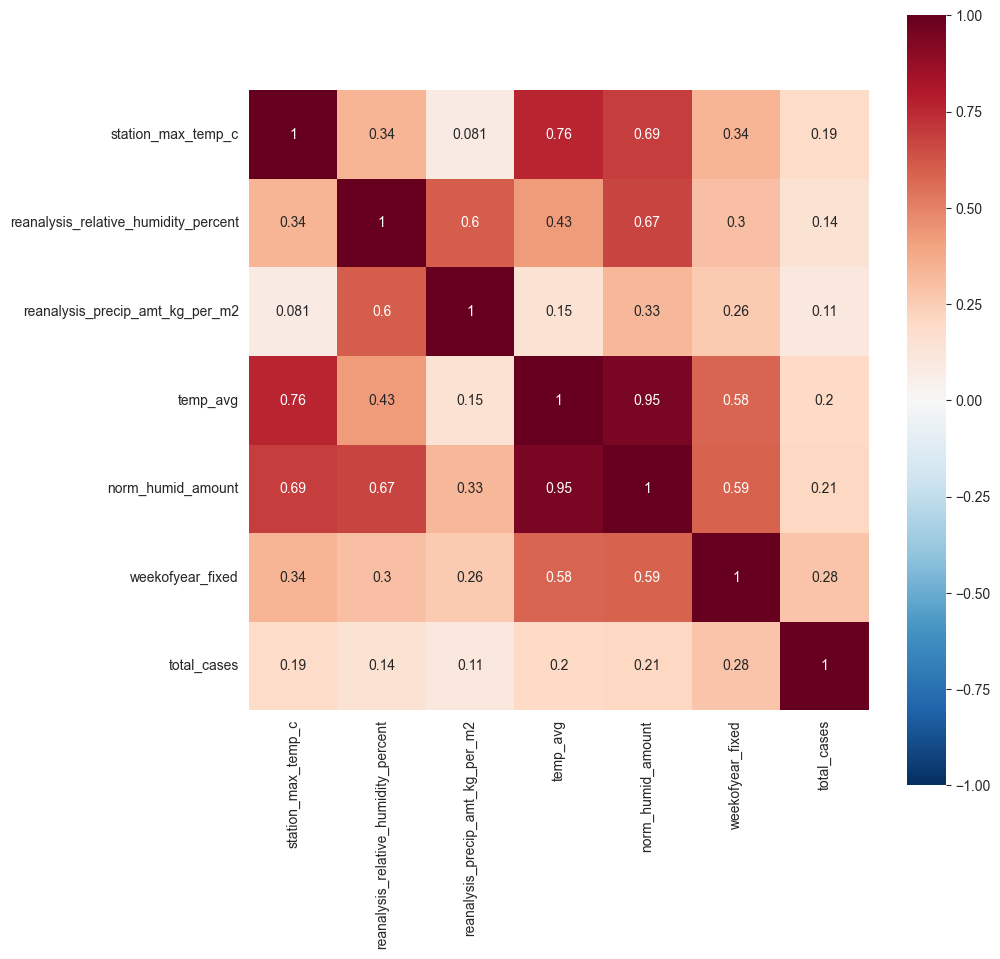

In [28]:
temp = df_sj_model_features.columns
df_corr = df_sj_model_features[temp].copy()
plt.figure(figsize=[10,10])
sns.heatmap(df_corr.corr(numeric_only=True),square=True, vmin=-1, vmax=1, 
                center=0, cmap='RdBu_r', annot=True)
plt.show()

# Aufbau des Models
Der Datensatz wird in Trainingsdaten und Testdaten aufgeteilt. Es wird mit einer 70-30 Aufteilung verfahren.

In [29]:
df_sj_lin_reg = df_sj_model_features.copy()
x = df_sj_lin_reg.drop(['total_cases'], axis=1)
y = df_sj_lin_reg['total_cases']
sj_x_train, sj_x_test, sj_y_train, sj_y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Lineare Regression
Die Korrealtionsmatrizen deuten auf eine mögliche lineare Beziehung der Variablen zur Zielvariable hin. Also wird die lineare Regression verwendet und durch Metriken überprüft, ob sich diese Annahme bestätigt.

In [30]:
def examine(y_pred, y_test):
    # Zeigt die tatsächlichen Werte und die ermittelten Werte in einer Grafik
    c = pd.DataFrame({
        'true' : y_test,
        'predicted' : y_pred
     })
    c = c.sort_index()
    plt.figure(figsize=[15,4])
    plt.plot(c.true, color='green')
    plt.plot(c.predicted, color='red')
    plt.show()

In [31]:
def output_with_metrics(model,x_train,y_train,x_test,y_test,y_pred):
    # Berechnet den Cross Validation Score
    # Berechnet den Mean Absolute Error, was für die Bewertung auf DrivenDate verwendet wird
    # Berechnet den R Squared Error
    # Gibt die Grafik aus
    print(cross_val_score(model,x_train,y_train,scoring='neg_mean_absolute_error', cv=4))
    print(mean_absolute_error(y_test,y_pred,multioutput='uniform_average'))
    print(model.score(x_test,y_test))
    examine(y_pred, y_test)

[-26.6070661  -32.19306121 -28.62898988 -21.49441362]
28.621345921132253
0.08751794019756809


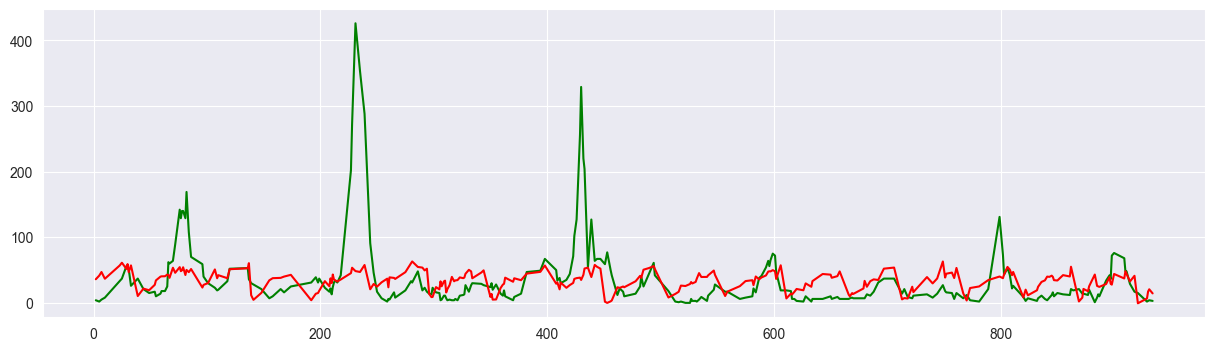

In [32]:
linear_reg_unchanged_sj = LinearRegression()
linear_reg_unchanged_sj.fit(sj_x_train,sj_y_train)
y_pred_linear_reg = linear_reg_unchanged_sj.predict(sj_x_test)
output_with_metrics(linear_reg_unchanged_sj,sj_x_train,sj_y_train,sj_x_test,sj_y_test,y_pred_linear_reg)

## Feature Engineering
Es bleibt zu Fragen, ob die Ergebnisse noch verbessert werden können.
### Saisonaler Aspekt der Zeitreihe
Durch klassische Regression geht die Komponente der Zeit verloren. Da der Datensatz in einer Zeitreihe vorliegt, müssen künstliche Variablen berechnet werden, damit der Aspekt der Zeit nicht ganz verloren geht. 
Anhand der Zeitreihendekomposition können Muster wie Trend oder Saison erkannt werden, die dabei helfen präzisere Vorhersagen zu leisten.

In [33]:
def time_series_decomp(df,y,ticks):
    result = seasonal_decompose(df[y],period=52)
    seasonal = result.seasonal
    trend = result.trend
    resid = result.resid
    plt.figure(figsize=(12, 8))
    plt.subplot(4, 1, 1)
    plt.plot(df[y], label='Original')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 2)
    plt.plot(seasonal, label='Seasonal')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 3)
    plt.plot(trend, label='Trend')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.subplot(4, 1, 4)
    plt.plot(resid, label='Residual')
    plt.legend(loc='upper left')
    plt.xticks(ticks)
    
    plt.title(y)
    plt.tight_layout()
    plt.show()

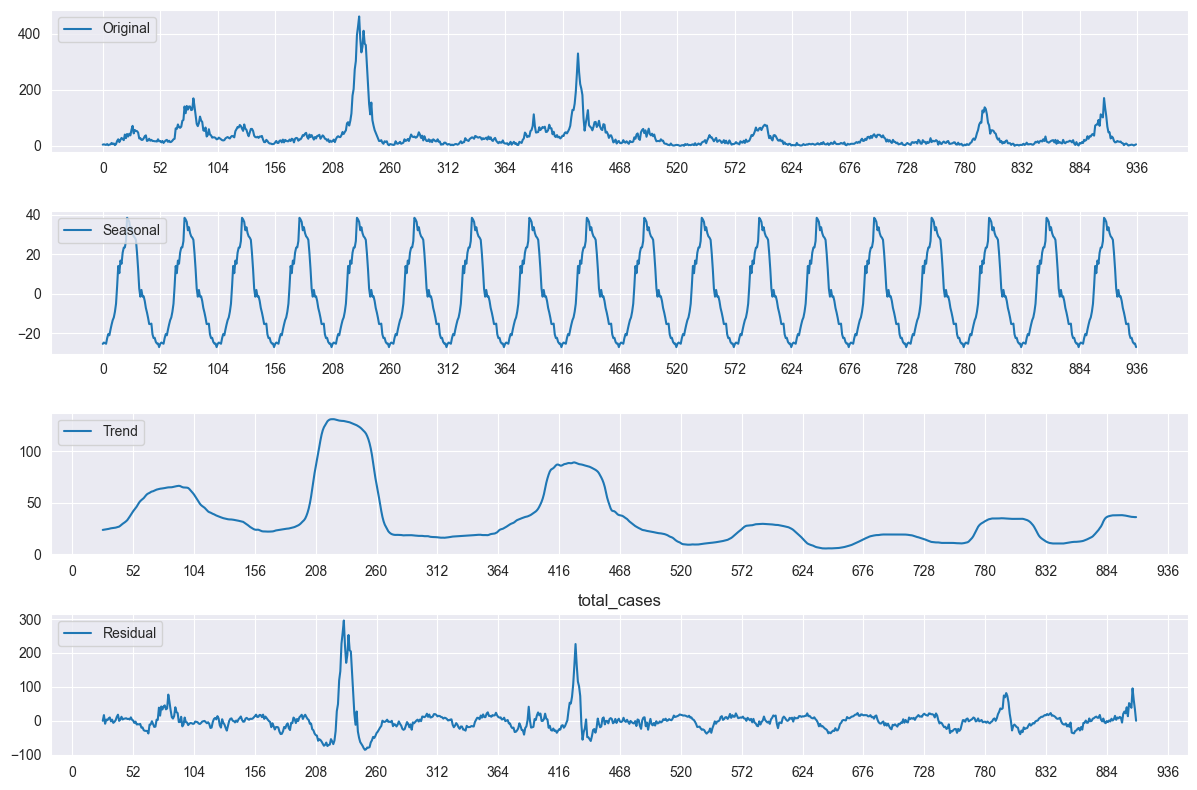

In [34]:
ticks = [0,52,104,156,208,260,312,364,416,468,520,572,624,676,728,780,832,884,936]
time_series_decomp(df_sj_model_features,'total_cases',ticks)

Die Trend-Komponente ist ungefähr 2 Wochen nach hinten verschoben, was auf die Inkubationszeit hinweisen kann, die beim Dengue Virus bei 1 bis zu 12 Tagen liegt.
Die Saison-Komponente zeigt, dass sich die Höhepunkte regelmäßig wiederholen. Um näheren Einblick zu bekommen, können die Wochen jedes Jahres abgebildet werden

In [35]:
df_sj_lineplot = df_sj_train[['weekofyear_fixed','year']].copy()
df_sj_lineplot['total_cases'] = df_sj_labels['total_cases'].copy()

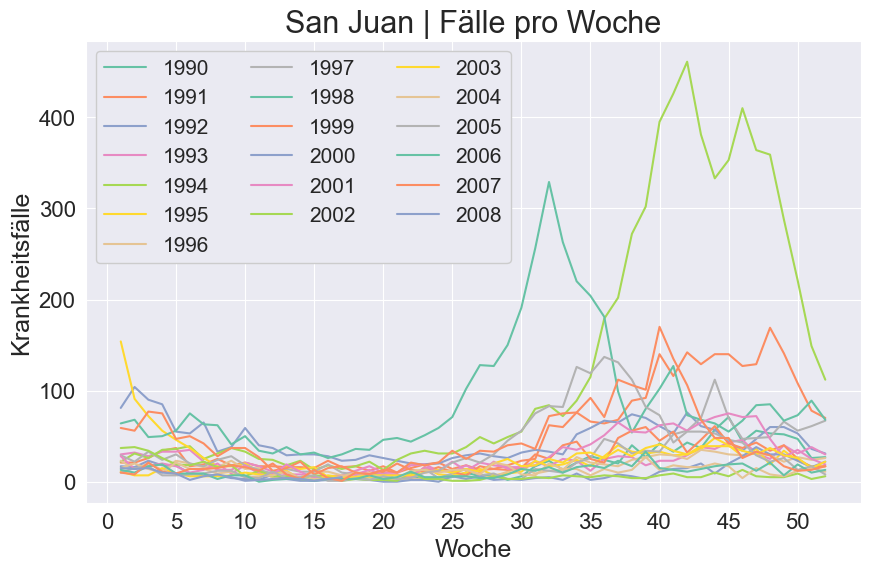

In [36]:
plt.figure(figsize=[10,6])
sns.lineplot(x='weekofyear_fixed',y='total_cases', hue='year',
                data=df_sj_lineplot, palette='Set2',legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})    
plt.ylabel('Krankheitsfälle',size=18)
plt.xlabel('Woche',size=18)
plt.xticks([0,5,10,15,20,25,30,35,40,45,50], size=16)
plt.yticks(size=16)
plt.title('San Juan | Fälle pro Woche', size=22)
plt.show()

Man kann drei Phasen im Jahr sehen: 
1.  Woche 1-11: Abnehmende Fallanzahl
2.  Woche 12-22: Gleichbleibende Fallanzahl mit Minima
3.  Woche 23-52: stark steigende Fallanzahl mit Maxima

Diese können mithilfe von Feature Engineering mit eigenen Attributen im DataFrame repräsentiert werden. 

In [37]:
for index, row in df_sj_train.iterrows():
    phase = 0
    if 0 <= row['weekofyear_fixed'] <= 11:
        phase = 1
    elif 12 <= row['weekofyear_fixed'] <= 22:
        phase = 2
    elif 23 <= row['weekofyear_fixed'] <= 52:
        phase = 3

    df_sj_model_features.loc[index, 'phase1'] = 1 if phase == 1 else 0
    df_sj_model_features.loc[index, 'phase2'] = 1 if phase == 2 else 0
    df_sj_model_features.loc[index, 'phase3'] = 1 if phase == 3 else 0

Nun wird überprüft, ob die Phasen auch mit der Zielvariablen korrelieren

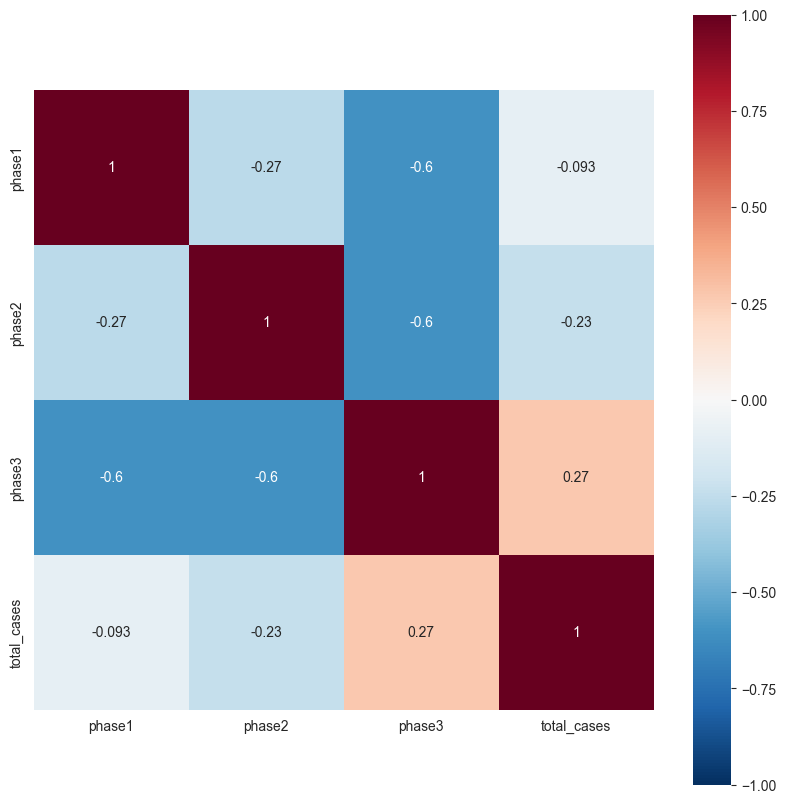

In [38]:
correlation_matrix(df_sj_model_features,df_sj_model_features,['phase1','phase2','phase3'],True)

Phase 3 korreliert mit der Zielvariable. Phase 2 korreliert negativ mit der Zielvariable, also gibt es einen negativen linearen Verlauf, der auch miteinbezogen werden kann. Nur Phase 1 korreliert fast gar nicht und wird ausgeschlossen.

In [39]:
df_sj_model_features.drop(columns=['phase1'],inplace=True)

Nun wird wieder die lineare Regression durchgeführt.

In [40]:
df_sj_lin_reg_phase = df_sj_model_features.copy()
x = df_sj_lin_reg_phase.drop(['total_cases'], axis=1)
y = df_sj_lin_reg_phase['total_cases']
sj_x_train, sj_x_test, sj_y_train, sj_y_test = train_test_split(x, y, test_size=0.3, random_state=42)

[-26.02048348 -30.45364106 -26.02013407 -21.51309824]
27.473951363477912
0.13229268465331823


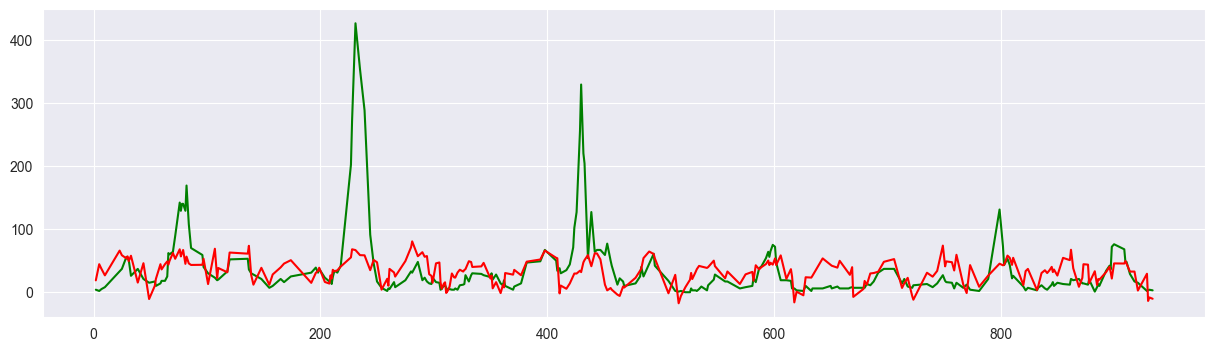

In [41]:
linear_reg_phases_sj = LinearRegression()
linear_reg_phases_sj.fit(sj_x_train,sj_y_train)
y_pred_linear_reg = linear_reg_phases_sj.predict(sj_x_test)
output_with_metrics(linear_reg_phases_sj,sj_x_train,sj_y_train,sj_x_test,sj_y_test,y_pred_linear_reg)

## Random Forest Regression
Die Random Forest Regression ist ein Ensemble Modell das mehrere Modelle vereint und dadurch genauer sein kann. Mit der Random Forest Regression werden mehrere Entscheidungsbäume aufgebaut und ihre Ergebnisse werden gemittelt. Dies ermöglicht es nicht-lineare Beziehungen besser vorherzusagen. 

In [42]:
x = df_sj_lin_reg_phase.drop(['total_cases'], axis=1)
y = df_sj_lin_reg_phase['total_cases']
sj_x_train_rndm, sj_x_test_rndm, sj_y_train_rndm, sj_y_test_rndm = train_test_split(x, y, test_size=0.3, random_state=42)

In [93]:
df_sj_lin_reg_phase

station_max_temp_c  reanalysis_relative_humidity_percent  \
0              0.303371                              0.318138   
1              0.561798                              0.510214   
2              0.617978                              0.734988   
3              0.741573                              0.652660   
4              0.932584                              0.658555   
..                  ...                                   ...   
931            0.370787                              0.360433   
932            0.438202                              0.377365   
933            0.303371                              0.397861   
934            0.303371                              0.266315   
935            0.561798                              0.490609   

     reanalysis_precip_amt_kg_per_m2  temp_avg  norm_humid_amount  \
0                           0.056091  0.324516           0.297392   
1                           0.031446  0.481929           0.473460   
2                           0.045749  0.551015           0.664509   
3                           0.024365  0.599826           0.641761   
4                           0.021385  0.692043           0.711300   
..                               ...       ...                ...   
931                         0.013234  0.267055           0.249676   
932                         0.006433  0.429826           0.381542   
933                         0.061350  0.334942           0.319586   
934                         0.008449  0.350606           0.277418   
935                         0.003804  0.520972           0.512114   

     weekofyear_fixed  total_cases  phase2  phase3  
0                  18            4     1.0     0.0  
1                  19            5     1.0     0.0  
2                  20            4     1.0     0.0  
3                  21            3     1.0     0.0  
4                  22            6     1.0     0.0  
..                ...          ...     ...     ...  
931                13            4     1.0     0.0  
932                14            3     1.0     0.0  
933                15            1     1.0     0.0  
934                16            3     1.0     0.0  
935                17            5     1.0     0.0  

[936 rows x 9 columns]

[-24.84484756 -29.0064939  -23.64820122 -20.62092025]
25.567864768683272
0.20717279165584568


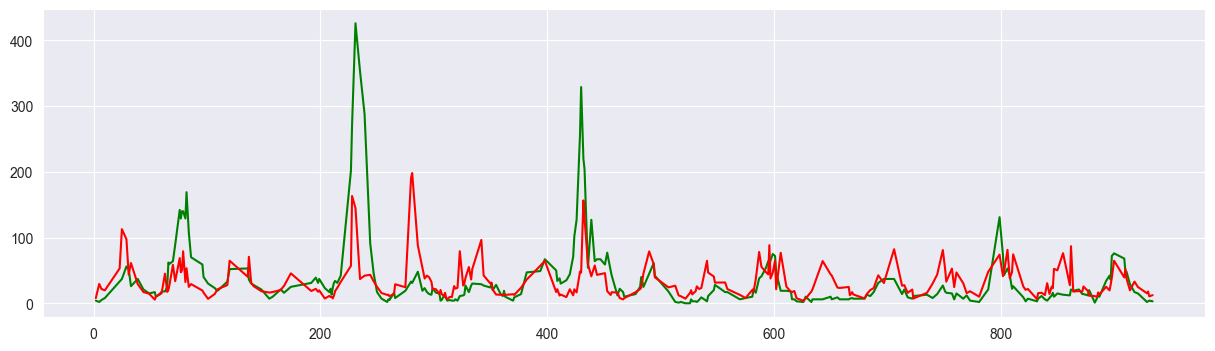

In [43]:
rndm_forest_regr_feat_eng_sj = RandomForestRegressor(criterion="absolute_error", random_state=40)
rndm_forest_regr_feat_eng_sj.fit(sj_x_train_rndm,sj_y_train_rndm)
y_pred_rndm = rndm_forest_regr_feat_eng_sj.predict(sj_x_test_rndm)
output_with_metrics(rndm_forest_regr_feat_eng_sj,sj_x_train_rndm,sj_y_train_rndm,sj_x_test_rndm,sj_y_test_rndm,y_pred_rndm)

## Feature Importance
Die Feature Importance wurde schon durch Verwendung des Korrelationsindexes durchgeführt. Da die ausgewählten Variablen den Datensatz nicht gut beschreiben (weil sie nicht-linear sind) wird nun eine Feature Importance über alle Variablen mithilfe von Random Forest durchgeführt. Das Ziel ist es, die für die Vorhersage wichtigen Features zu ermitteln.

In [44]:
df_all_features = df_sj_train.copy()
df_all_features.drop(columns=["total_cases", "year", "city", "week_start_date"],
                     inplace=True)
df_all_features = df_all_features.interpolate(method='linear', limit_direction='both', limit=26)
df_all_features['phase2'] = df_sj_lin_reg_phase['phase2'].copy()
df_all_features['phase3'] = df_sj_lin_reg_phase['phase3'].copy()
df_all_features['phase1'] = 0
df_all_features.loc[(df_all_features['phase2'] == 0) & (df_all_features['phase3'] == 0), 'phase1'] = 1
df_all_features['temp_avg'] = df_sj_model_features['temp_avg']

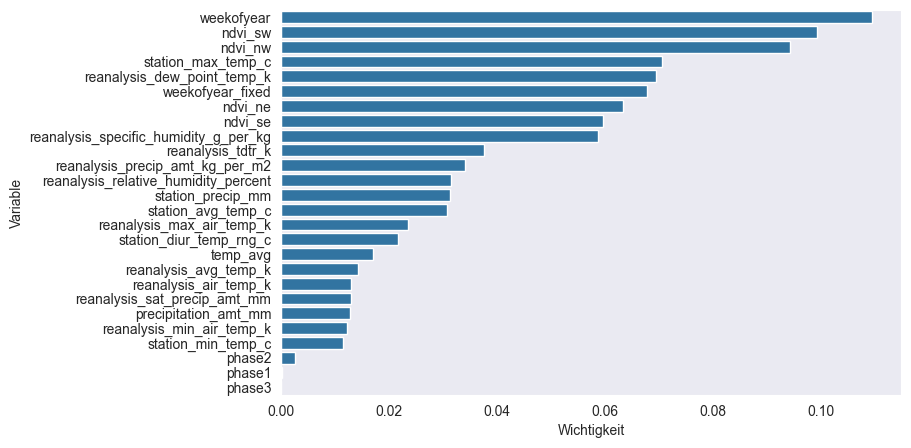

In [45]:
X = df_all_features
y = df_sj_labels['total_cases']
names = df_all_features.columns.values.tolist()

rf_classifier = RandomForestRegressor()
rf_classifier.fit(X, y)
importance = {
    'Variable': names,
    'Wichtigkeit': rf_classifier.feature_importances_
}
feature_importance = pd.DataFrame(importance)
plt.figure(figsize=(8, 5))
plt.grid()
sns.barplot(x="Wichtigkeit", y="Variable", data=feature_importance.sort_values(by="Wichtigkeit", ascending=False))
selected_features = feature_importance[feature_importance['Wichtigkeit'] >= 0.045]
selected_feature_names = selected_features['Variable'].tolist()

[-19.80323171 -28.71496951 -21.00332317 -17.23592025]
23.75163701067616
0.10886273107755284


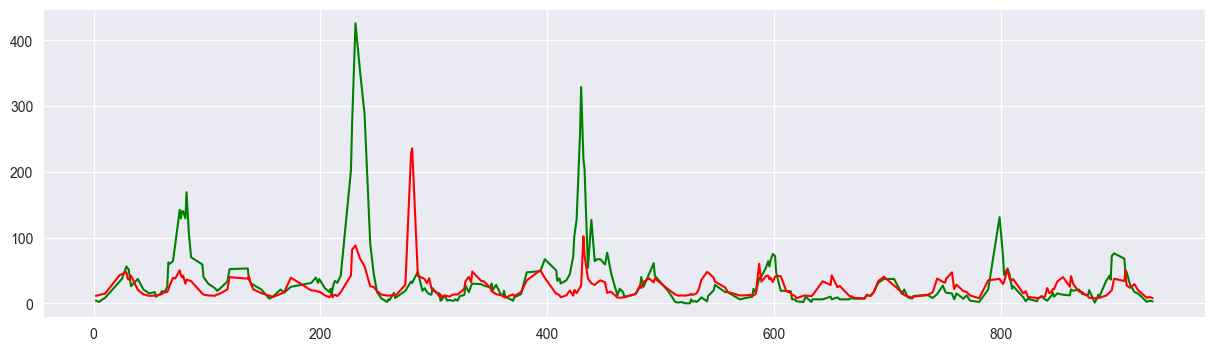

In [46]:
x = df_all_features[selected_feature_names]
y = df_sj_labels['total_cases']
sj_x_train_rndm, sj_x_test_rndm, sj_y_train_rndm, sj_y_test_rndm = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)
rndm_forest_regr_feat_imp_sj = RandomForestRegressor(criterion="absolute_error",max_depth=4)
rndm_forest_regr_feat_imp_sj.fit(sj_x_train_rndm, sj_y_train_rndm)
y_pred_rndm = rndm_forest_regr_feat_imp_sj.predict(sj_x_test_rndm)
output_with_metrics(rndm_forest_regr_feat_imp_sj,sj_x_train_rndm,sj_y_train_rndm,sj_x_test_rndm,sj_y_test_rndm,y_pred_rndm)

# Ergebnis
Am schlechtesten hat die simple (multivariable) lineare Regression abgeschnitten, was auf die fehlende Saisonalität zurückzuführen ist. Diese Aussage kräftigt sich bei Betrachtung der linearen Regression mit den Phasen. Da beide Modelle nicht gut abschneiden, kann gesagt werden, dass keine lineare Beziehung zwischen den Features und der Zielvariable vorliegt.

Die Random Forest Regression hingegen unterstützt sowohl lineare, als auch nicht-lineare Beziehungen zwischen Features und Zielvariable, daher wurde diese als nächstes eingesetzt. Das Ergebnis ist, sowie die anderen davor, unzureichend.
Dies kann auf die Verwendung der Korrelationskoeffizienten zurückgeführt werden, da dieser anhand der Linearität zur Zielvariable berechnet wird und, wie schon herausgefunden, keine Linearität vorliegt.

Im nächsten Schritt wurde deswegen eine Feature Importance durchgeführt, um die Features aufzudecken, die den größten Einfluss auf die Zielvariable haben.
  
Am besten abgeschnitten hat die Random Forest Regression nach der Feature Importance.

TODO: Überprüfe, ob RFR vor oder nach Feature Importance besser ist. Wenn davor, dann passt die hypothese (unsere annahme).

# Iquitos Datensatz 
Die nächsten Schritte der Visualisierung der Daten sind die gleichen wie im San Juan Datensatz und werden daher nur bei ungewöhnlichen/sich stark unterscheidenden Befunden erklärt.
## Datenvisualisierung
### Fehlende Daten

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\1660113403.py:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  barplot.set_xticklabels(barplot.get_xticklabels(), rotation=40, ha="right")


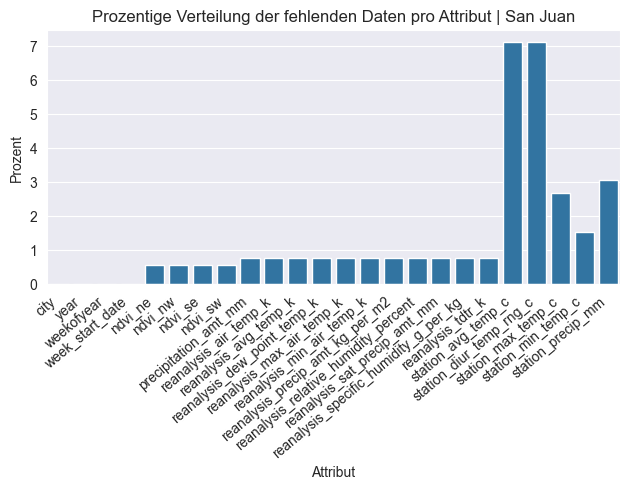

In [47]:
missing_data_percent(df_iq_train)

### Werteverteilung

In [48]:
max_min_avg(df_iq_train)

max         min         avg
ndvi_ne                                  0.493400   -0.406250    0.057925
ndvi_nw                                  0.437100   -0.456100    0.067469
ndvi_se                                  0.393129   -0.015533    0.177655
ndvi_sw                                  0.381420   -0.063457    0.165956
precipitation_amt_mm                   390.600000    0.000000   35.470809
reanalysis_air_temp_k                  302.200000  295.938571  299.163653
reanalysis_avg_temp_k                  302.164286  296.114286  299.276920
reanalysis_dew_point_temp_k            297.795714  289.642857  295.109519
reanalysis_max_air_temp_k              304.300000  297.800000  301.398817
reanalysis_min_air_temp_k              299.900000  292.600000  297.301828
reanalysis_precip_amt_kg_per_m2        570.500000    0.000000   30.465419
reanalysis_relative_humidity_percent    87.575714   66.735714   78.568181
reanalysis_sat_precip_amt_mm           390.600000    0.000000   35.470809
reanalysis_specific_humidity_g_per_kg   19.440000   11.715714   16.552409
reanalysis_tdtr_k                        4.428571    1.357143    2.516267
station_avg_temp_c                      30.071429   22.842857   27.006528
station_diur_temp_rng_c                  9.914286    4.528571    6.757373
station_max_temp_c                      35.600000   26.700000   31.607957
station_min_temp_c                      25.600000   17.800000   22.600645
station_precip_mm                      305.900000    0.000000   26.785484

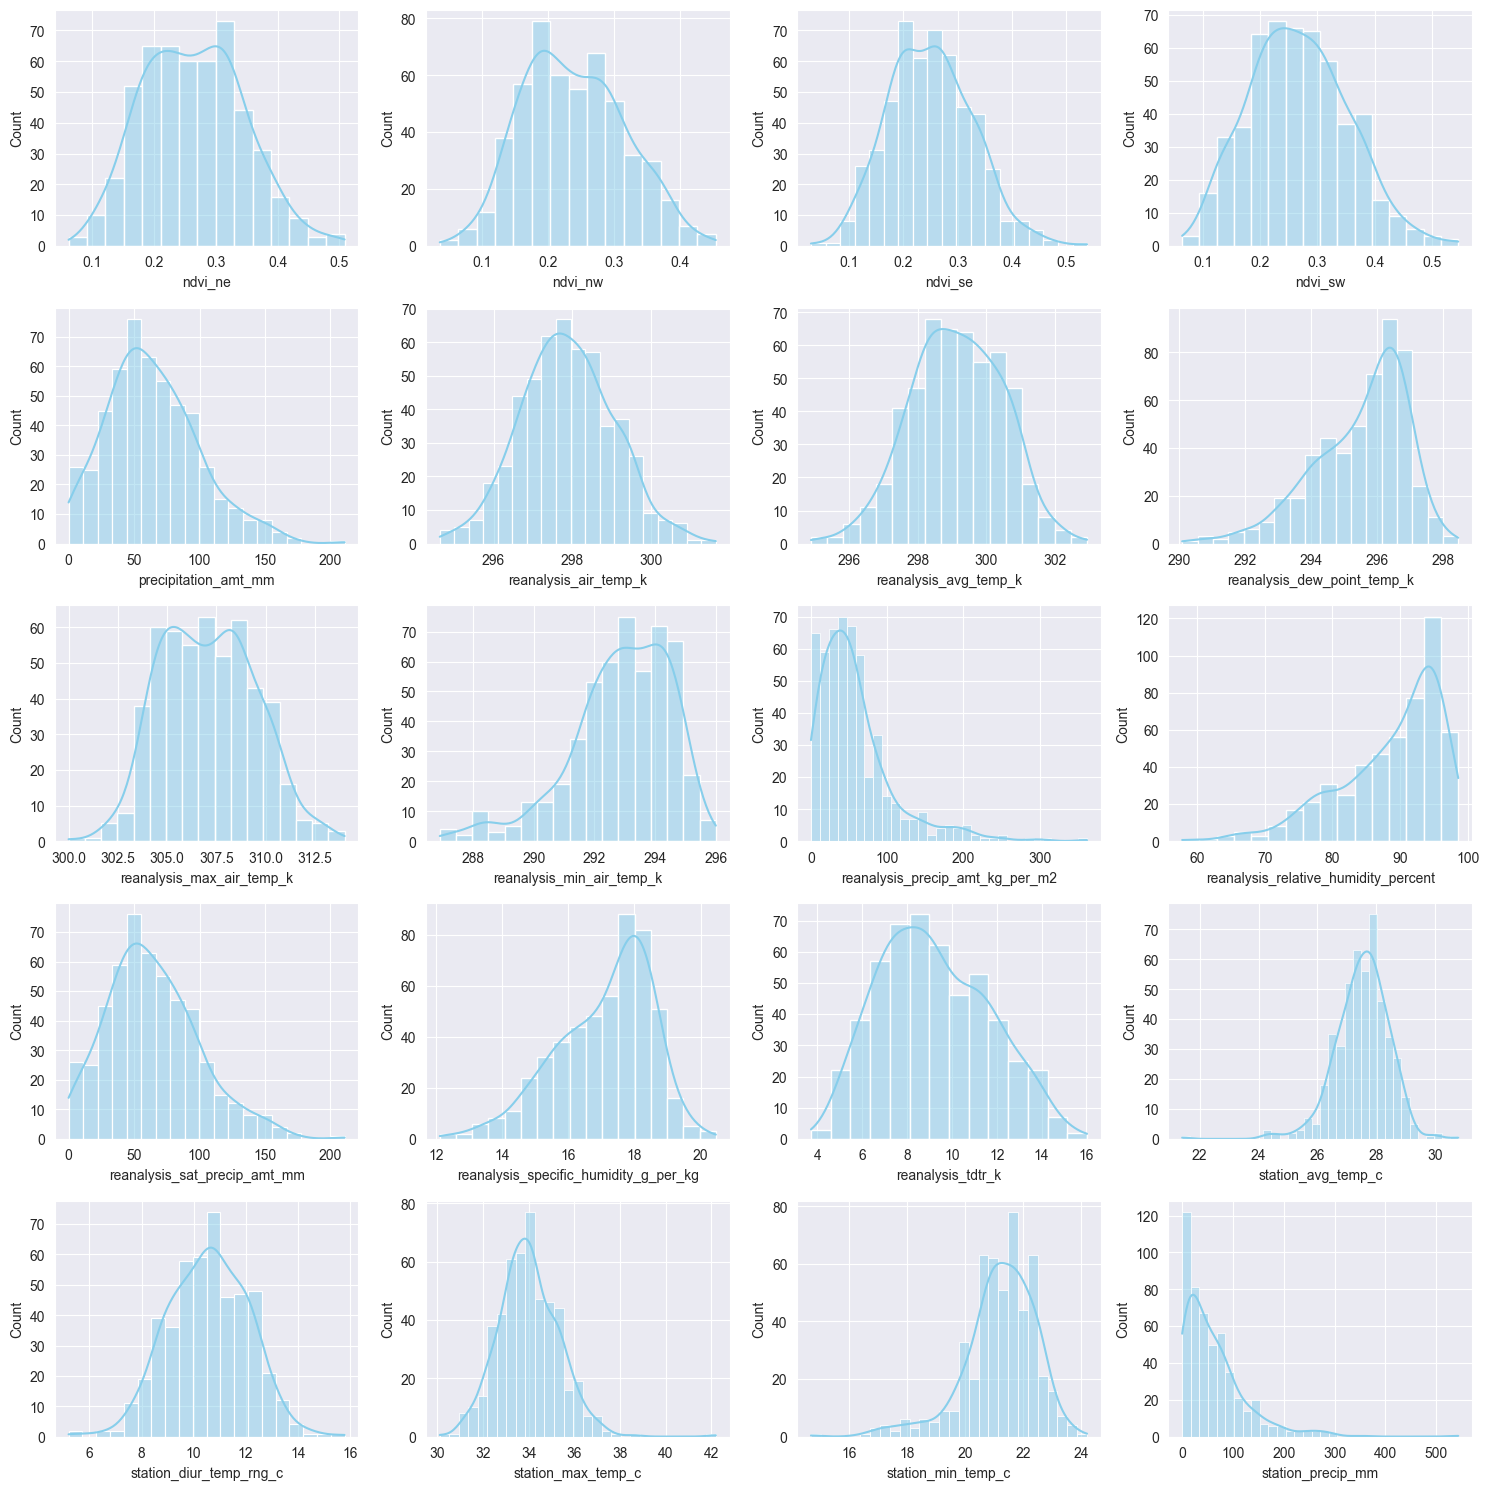

In [49]:
attribute_distribution_histogram(df_iq_ignored,5,4)

### Ausreißer

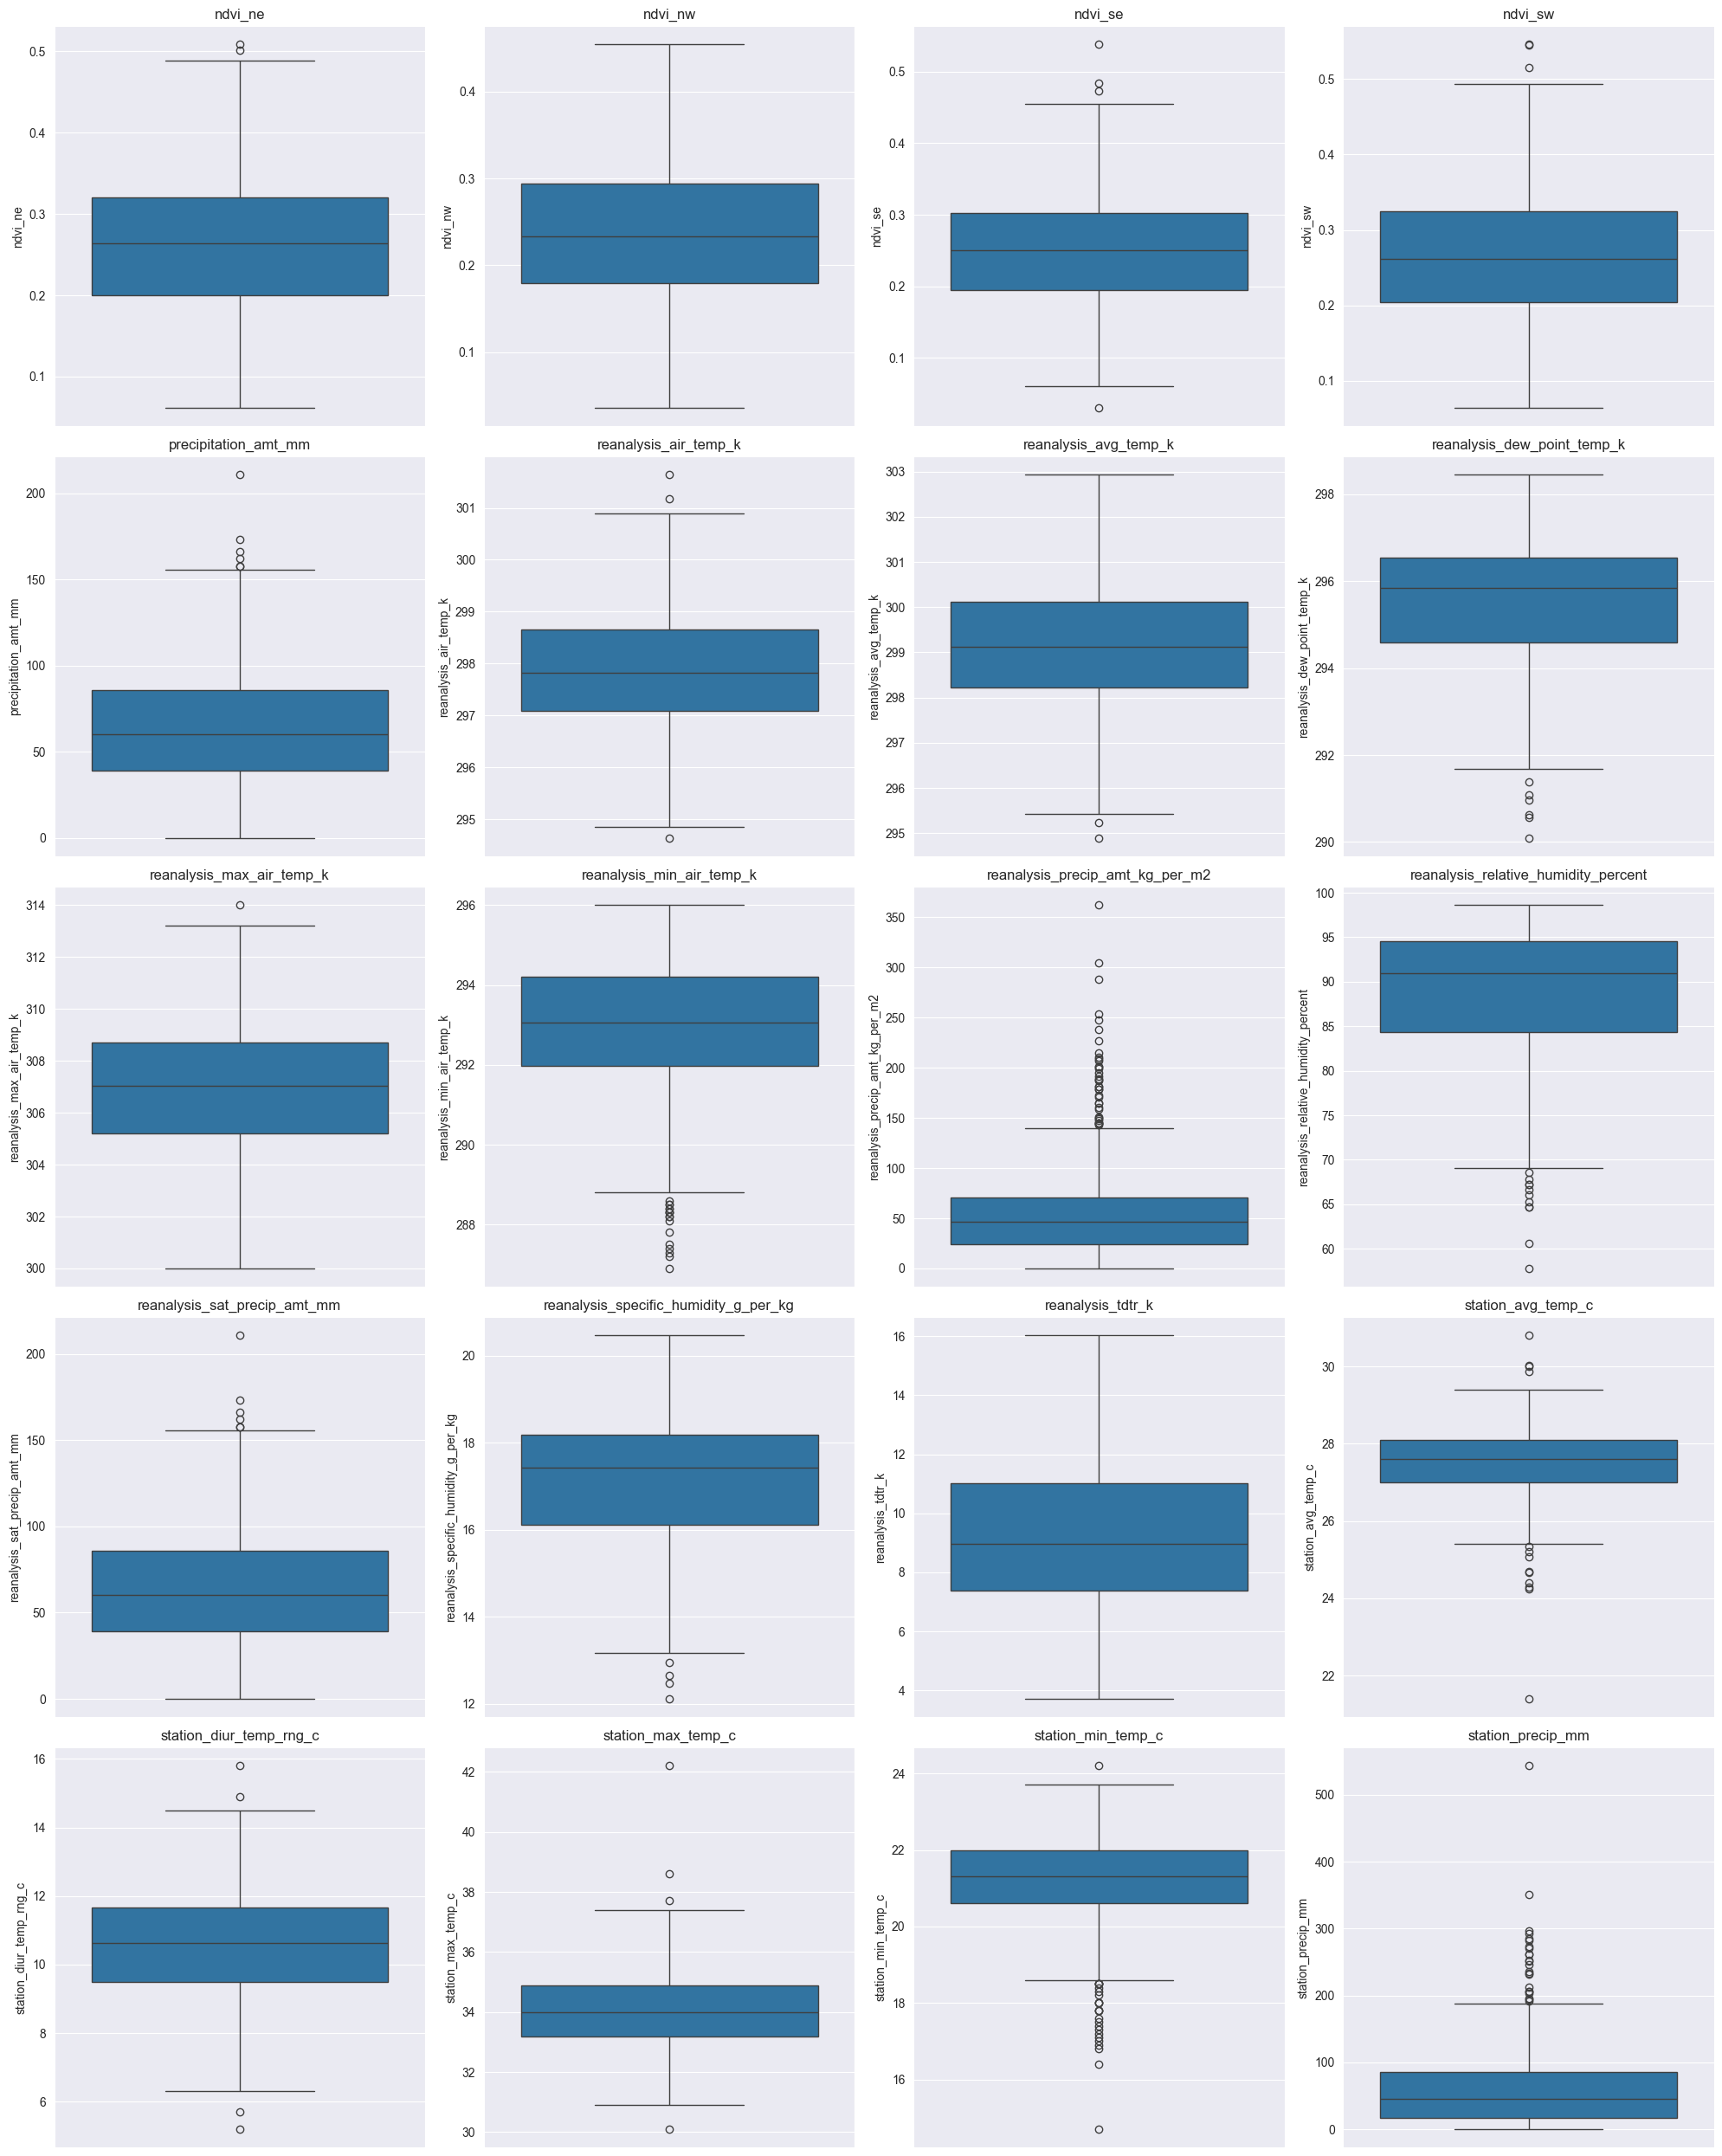

In [50]:
outlier_boxplot(df_iq_ignored)

## Korrelation
Die Korrelation des Iquitos-Datensatzes unterscheidet sich an manchen Stellen sehr von San Juan und an anderen Stellen ist die Korrelation ähnlich oder gleich geblieben. In der weiteren Analyse wird aufgedeckt, welche Attribute miteinander und mit der Zielvariable stark oder schwach korrelieren.

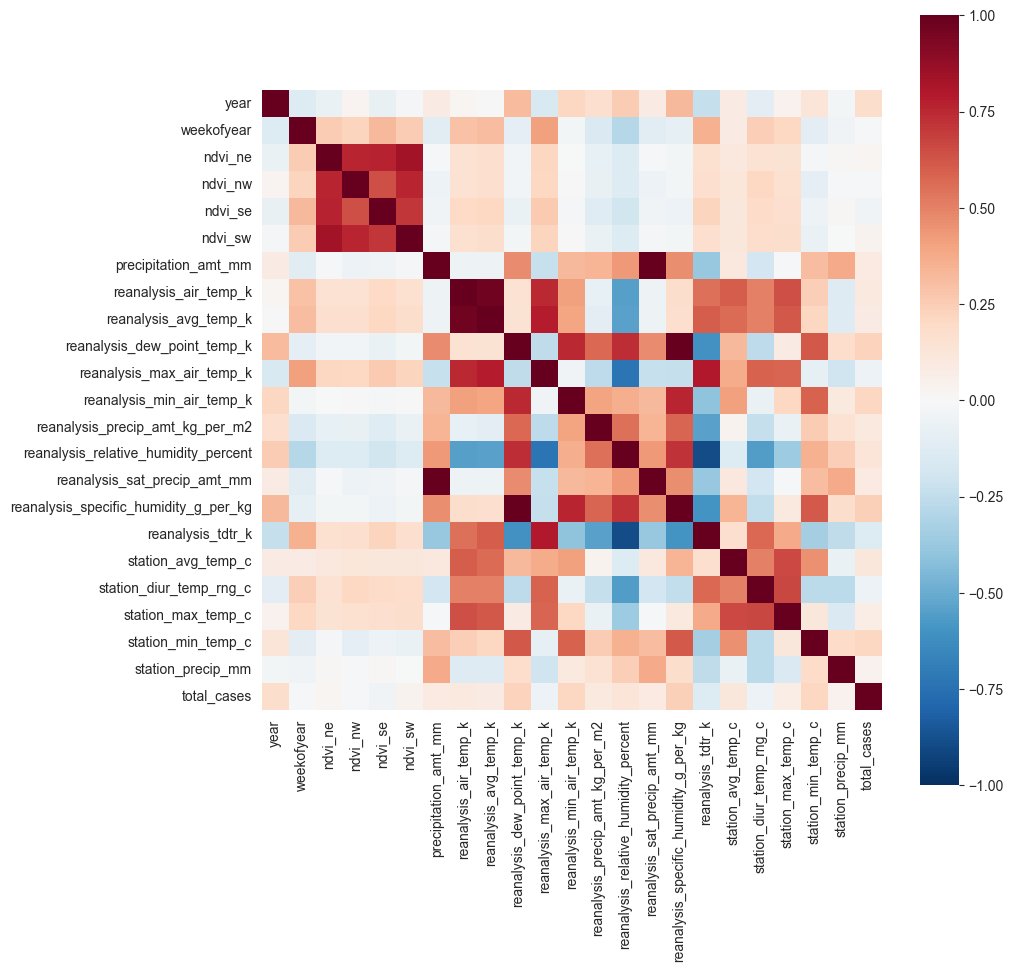

In [51]:
correlation_matrix(df_iq_train,df_iq_labels,df_iq_train.columns.tolist(),False)

Die Attribute der Temperatur korrelieren nicht mehr so stark untereinander und auch nicht mit der Zielvariable. Dafür korrelieren andere Attribute nun mehr mit der Zielvariable (z.B. 'reanalysis_min_air_temp_k'). Für die Auswahl der für das Model benötigten Variablen werden die am stärksten korrelierenden Variablen genommen ('reanalysis_dew_point_temp_k','reanalysis_min_air_temp_k','station_min_temp_c'). Wichtig ist auch Attribute zu beachten, die negativ mit der Zielvariable korrelieren, da sie eine negativ-lineare Beziehung aufweisen ('reanalysis_tdtr_k'). 

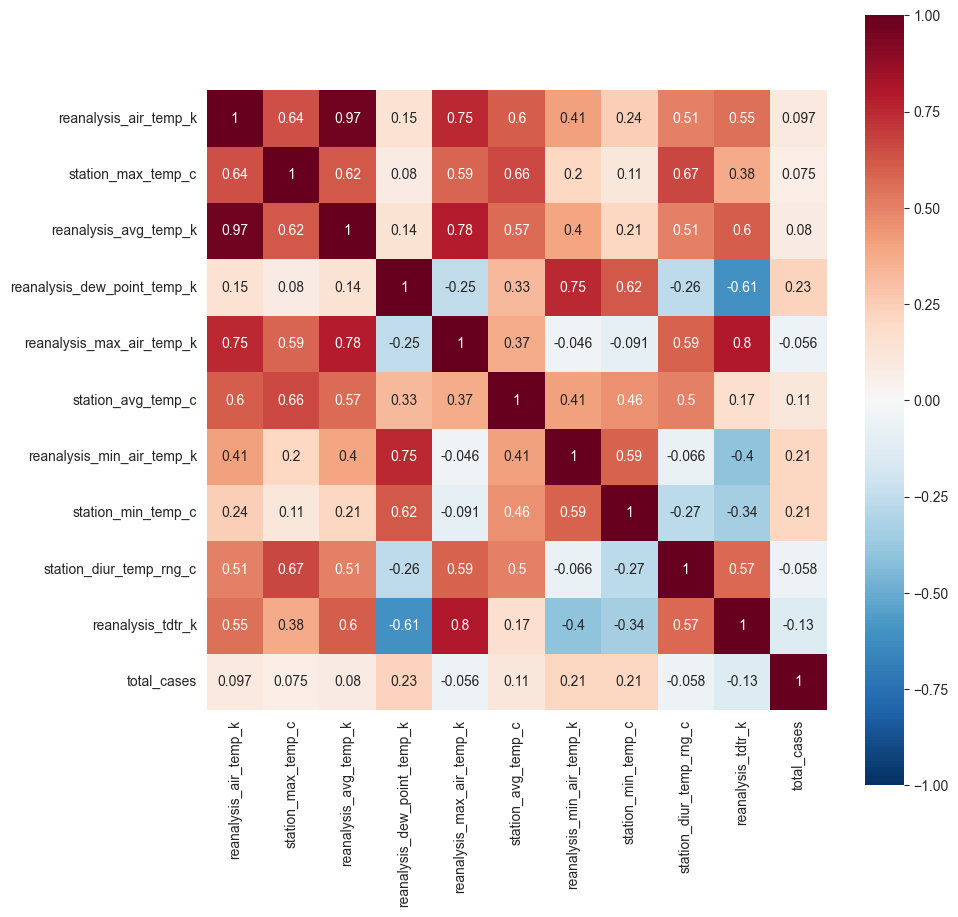

In [52]:
# Temperaturdaten
correlation_matrix(df_iq_train,df_iq_labels, ['reanalysis_air_temp_k',
                           'station_max_temp_c',
                           'reanalysis_avg_temp_k',
                           'reanalysis_dew_point_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'station_diur_temp_rng_c',
                           'reanalysis_tdtr_k',
                           ],True)

Auch bei den Niederschlagsdaten werden die meist-korrelierenden Attribute für das weitere verfahren ausgewählt ('reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent'). Hier ist die korrelation zwischen 'precipitation_amt_mm' und 'reanalysis_sat_precip_amt_mm' wieder identisch.

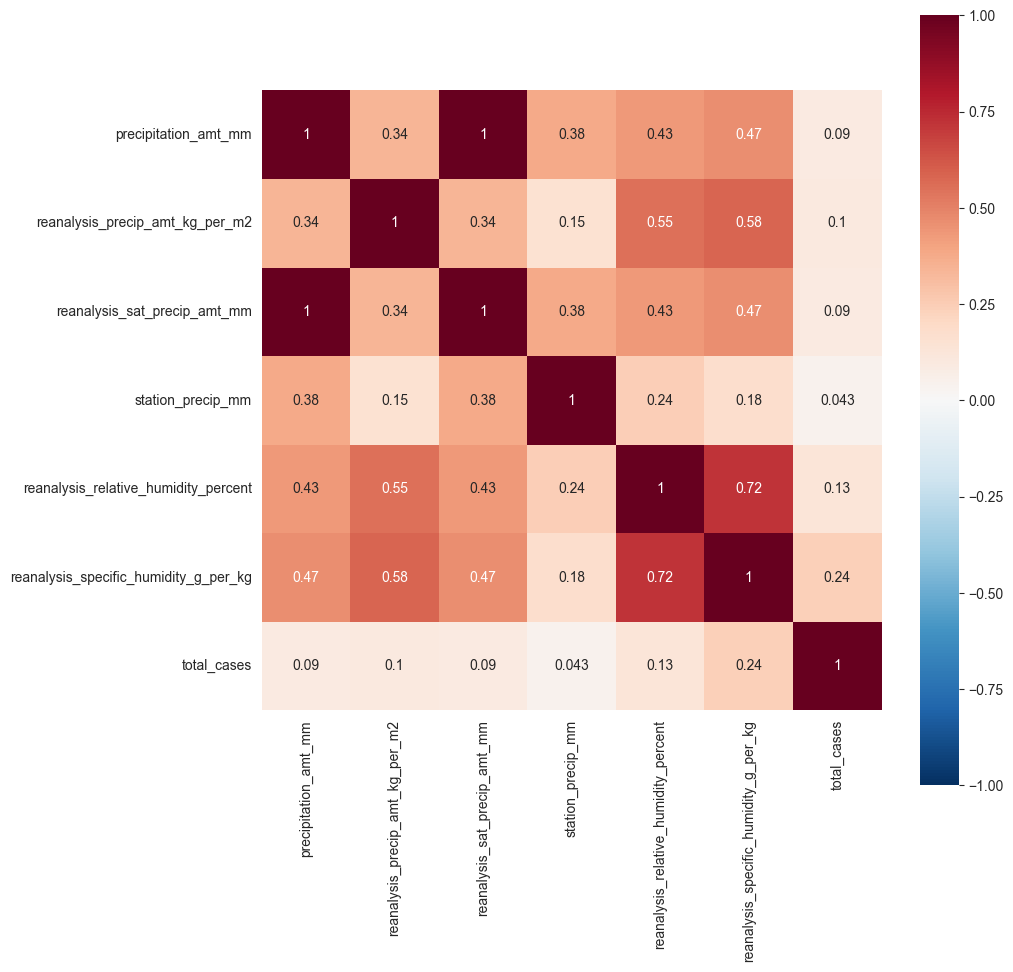

In [53]:
# Niederschlagsdaten
correlation_matrix(df_iq_train,df_iq_labels,['precipitation_amt_mm',
                             'reanalysis_precip_amt_kg_per_m2',
                             'reanalysis_sat_precip_amt_mm',
                             'station_precip_mm',
                             'reanalysis_relative_humidity_percent',
                             'reanalysis_specific_humidity_g_per_kg'],True)

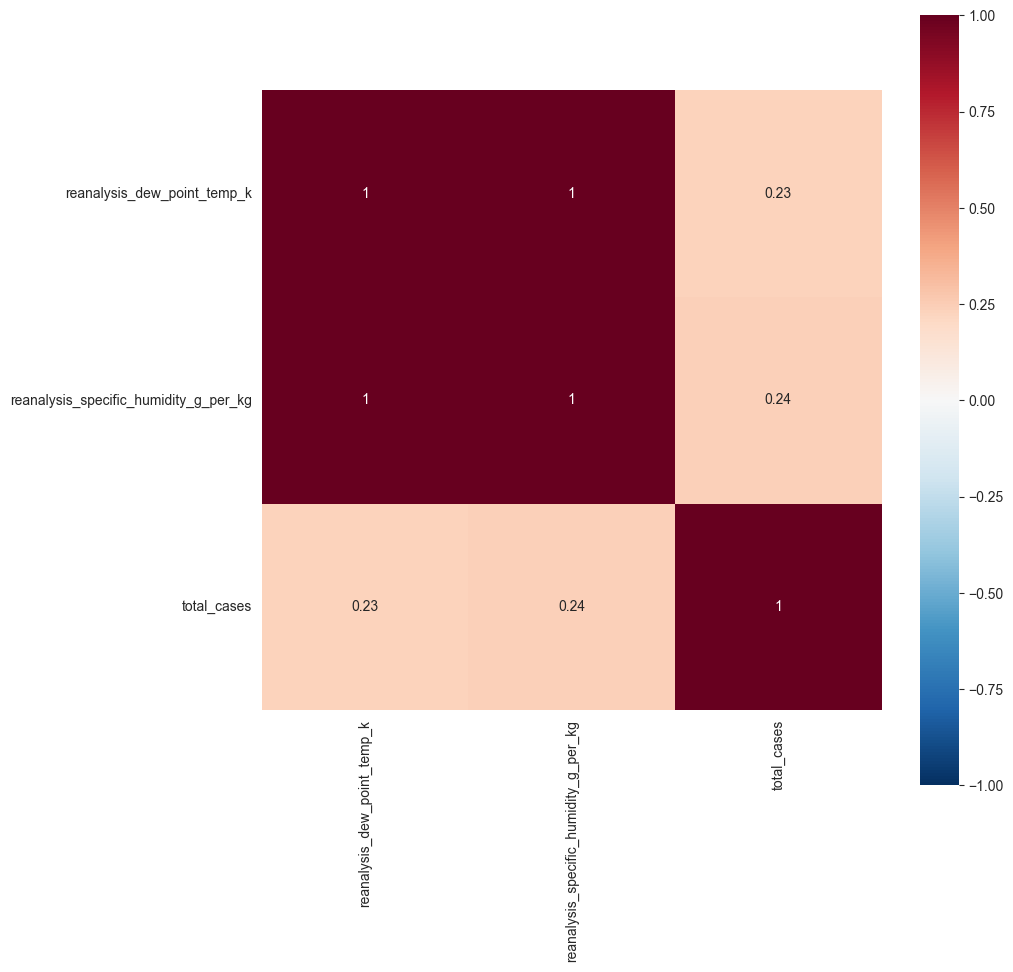

In [54]:
correlation_matrix(df_iq_train,df_iq_labels,['reanalysis_dew_point_temp_k',
                             'reanalysis_specific_humidity_g_per_kg'],True)

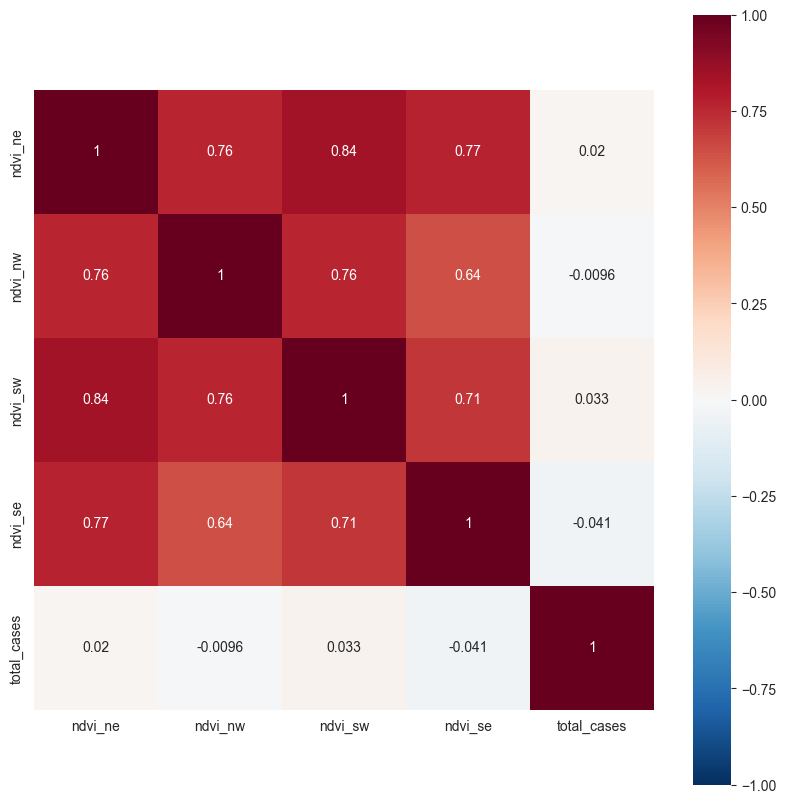

In [55]:
correlation_matrix(df_iq_train,df_iq_labels,['ndvi_ne','ndvi_nw','ndvi_sw','ndvi_se'],True)

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\3328193609.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train['total_cases']=df_iq_labels['total_cases']
C:\Users\rener\AppData\Local\Temp\ipykernel_25824\3328193609.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  iq_correlations = df_iq_train.corr()


<AxesSubplot: >

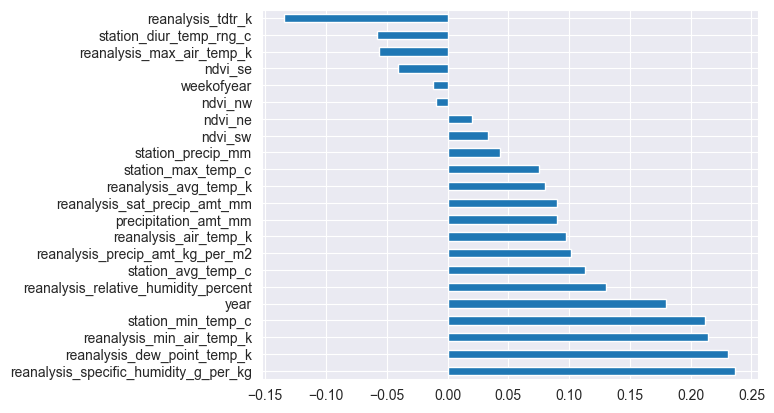

In [56]:
df_iq_train['total_cases']=df_iq_labels['total_cases']
iq_correlations = df_iq_train.corr()
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

# Datenpräparation
## Auswahl der Attribute

In [57]:
df_iq_model_features = df_iq_train[['reanalysis_dew_point_temp_k','reanalysis_min_air_temp_k','station_min_temp_c','reanalysis_tdtr_k','reanalysis_specific_humidity_g_per_kg','reanalysis_relative_humidity_percent','reanalysis_precip_amt_kg_per_m2','station_avg_temp_c']].copy()
df_iq_model_features['total_cases'] = df_iq_labels['total_cases'].copy()

## Behandlung von fehlenden Daten
Hier wurde wieder die Verbesserung von "conditg" verwendet. [Link](https://github.com/conditg/deng-ai/blob/master/Iquitos.ipynb)

In [58]:
#Increment all week values by one for all problem years
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2005,df_iq_train.weekofyear+1, df_iq_train.weekofyear)
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2006,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2010,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.weekofyear_fixed>52,1, df_iq_train.weekofyear_fixed)


#Increment all week values by one for all problem years
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.year==2012,df_iq_labels.weekofyear+1, df_iq_labels.weekofyear)
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.year==2011,df_iq_labels.weekofyear_fixed+1, df_iq_labels.weekofyear_fixed)

#Reduce any week values over 52 down to 1    
df_iq_labels.loc[:,'weekofyear_fixed'] = np.where(df_iq_labels.weekofyear_fixed>52,1, df_iq_labels.weekofyear_fixed)


C:\Users\rener\AppData\Local\Temp\ipykernel_25824\273905259.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2005,df_iq_train.weekofyear+1, df_iq_train.weekofyear)
C:\Users\rener\AppData\Local\Temp\ipykernel_25824\273905259.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iq_train.loc[:,'weekofyear_fixed'] = np.where(df_iq_train.year==2006,df_iq_train.weekofyear_fixed+1, df_iq_train.weekofyear_fixed)
C:\Users\rener\AppData\Local\Tem

In [59]:
df_iq_model_features['weekofyear_fixed'] = df_iq_train['weekofyear_fixed']
df_iq_model_features['weekofyear_fixed'] = df_iq_labels['weekofyear_fixed']

### Füllen von fehlenden Daten

In [60]:
df_iq_model_features = df_iq_model_features.interpolate(method='linear', limit_direction='both', limit=52)

# Aufbau des Models

In [61]:
df_iq_lin_reg = df_iq_model_features.copy()
x = df_iq_lin_reg.drop(['total_cases'], axis=1)
y = df_iq_lin_reg['total_cases']
iq_x_train, iq_x_test, iq_y_train, iq_y_test = train_test_split(x, y, test_size=0.3, random_state=42)

## Lineare Regression

[-7.3341107  -5.57351737 -6.99341409 -5.53011968]
6.936207768548238
0.018025201089274523


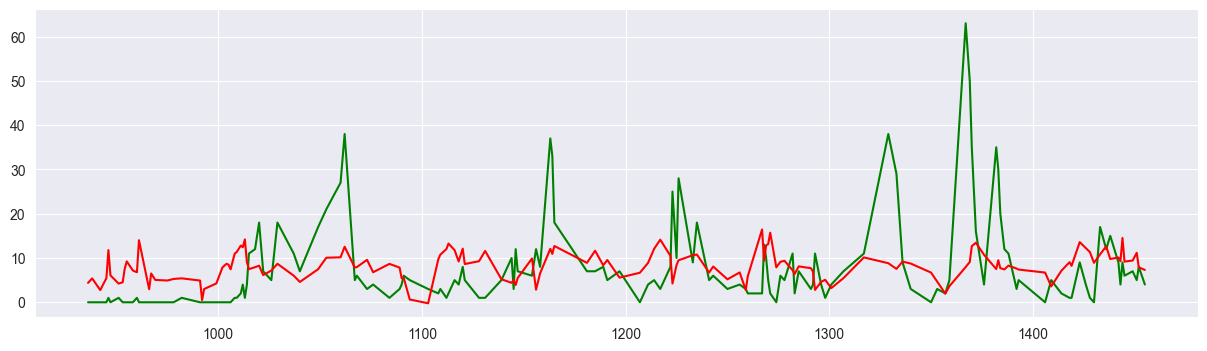

In [62]:
lin_reg_unchanged_iq = LinearRegression()
lin_reg_unchanged_iq.fit(iq_x_train,iq_y_train)
y_pred_linear_reg = lin_reg_unchanged_iq.predict(iq_x_test)
output_with_metrics(lin_reg_unchanged_iq,iq_x_train,iq_y_train,iq_x_test,iq_y_test,y_pred_linear_reg)

## Feature Engineering

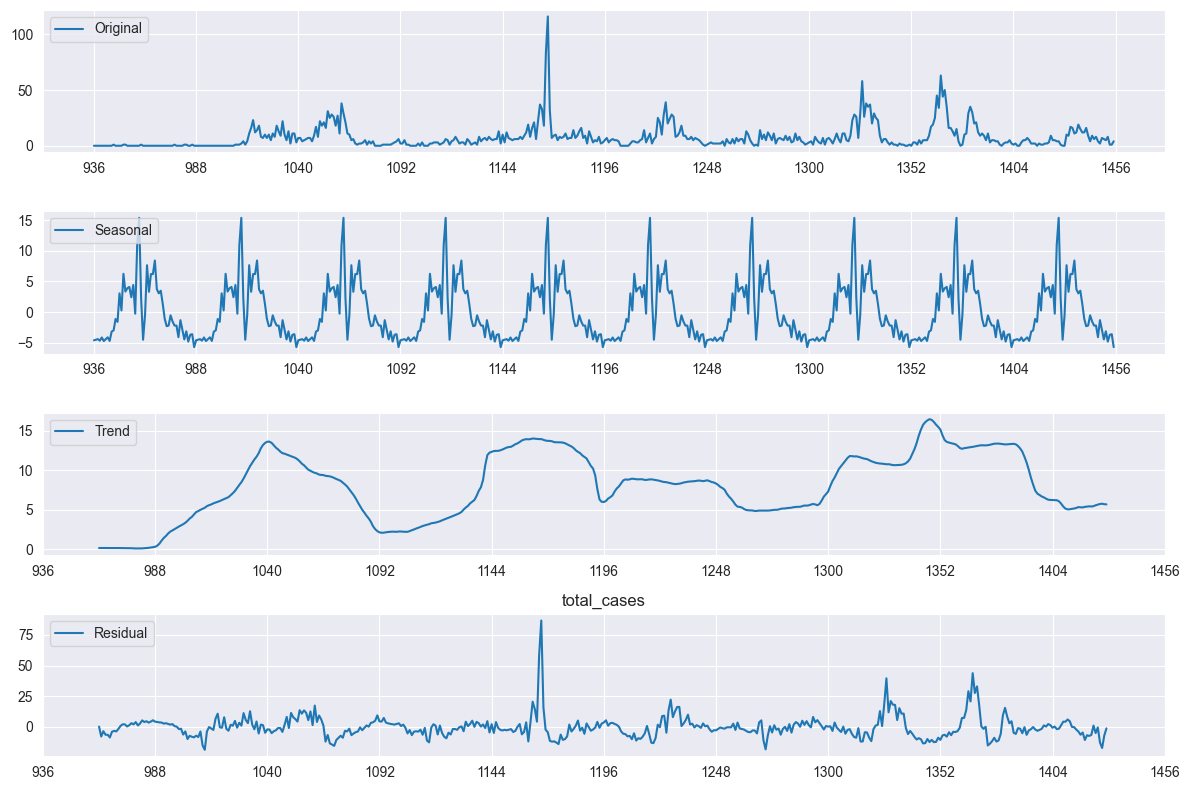

In [63]:
ticks = [936, 988, 1040, 1092, 1144, 1196, 1248, 1300, 1352, 1404, 1456]
time_series_decomp(df_iq_model_features,'total_cases',ticks)

In [64]:
df_iq_lineplot = df_iq_train[['weekofyear_fixed', 'year']].copy()
df_iq_lineplot['total_cases'] = df_iq_labels['total_cases'].copy()

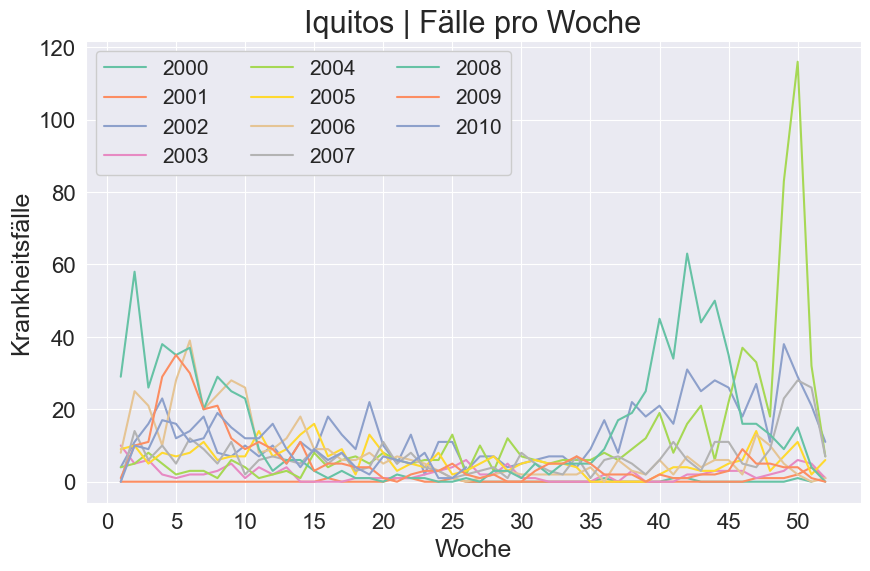

In [65]:
plt.figure(figsize=[10, 6])
sns.lineplot(x='weekofyear_fixed', y='total_cases', hue='year',
             data=df_iq_lineplot, palette='Set2', legend='full')
plt.legend(loc=2, framealpha=1, ncol=3, prop={'size': 15})
plt.ylabel('Krankheitsfälle', size=18)
plt.xlabel('Woche', size=18)
plt.xticks([0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50], size=16)
plt.yticks(size=16)
plt.title('Iquitos | Fälle pro Woche', size=22)
plt.show()

Im Iquitos Datensatz sind 4 Phasen zu erkennen:
1. Von Woche 1-12
2. Von Woche 13-24
3. Von Woche 25-36
4. Von Woche 36-52

In [66]:
df_iq_phase = df_iq_model_features.copy()
for index, row in df_iq_train.iterrows():
    phase = 0
    if 0 <= row['weekofyear_fixed'] <= 12:
        phase = 1
    elif 13 <= row['weekofyear_fixed'] <= 24:
        phase = 2
    elif 25 <= row['weekofyear_fixed'] <= 36:
        phase = 3
    elif 37 <= row['weekofyear_fixed'] <= 52:
        phase = 4

    df_iq_phase.loc[index, 'phase1'] = 1 if phase == 1 else 0
    df_iq_phase.loc[index, 'phase2'] = 1 if phase == 2 else 0
    df_iq_phase.loc[index, 'phase3'] = 1 if phase == 3 else 0
    df_iq_phase.loc[index, 'phase4'] = 1 if phase == 4 else 0

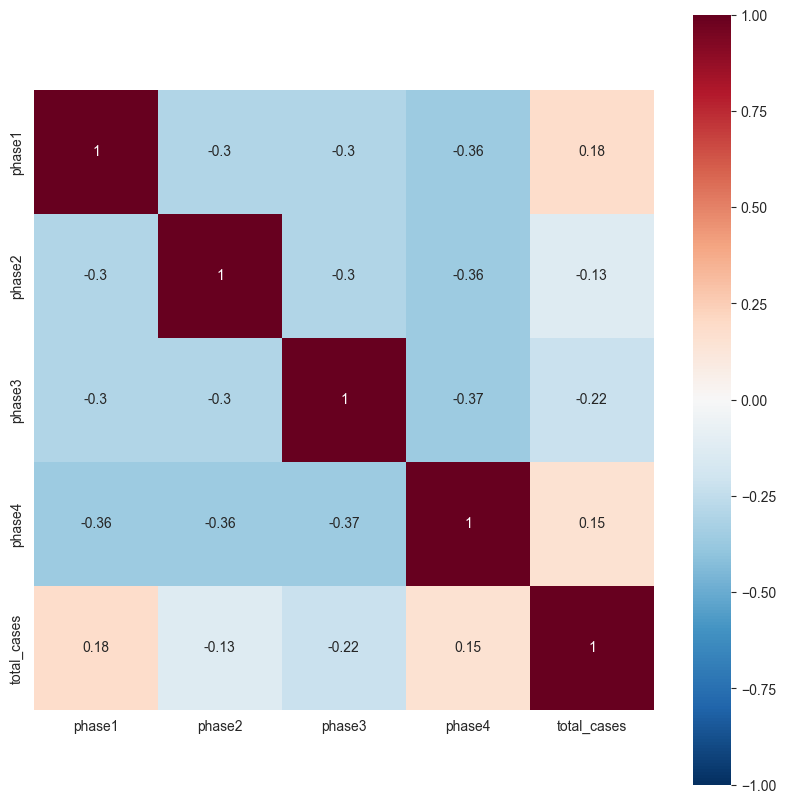

In [67]:
correlation_matrix(df_iq_phase,df_iq_phase,['phase1','phase2','phase3','phase4'],True)

Alle vier Phasen beeinflussen die Zielvariable positiv oder negativ, daher werden alle in die Vorhersage miteinbezogen. 

In [68]:
x = df_iq_phase.drop(['total_cases'], axis=1)
y = df_iq_phase['total_cases']
iq_x_train, iq_x_test, iq_y_train, iq_y_test = train_test_split(x, y, test_size=0.3, random_state=42)

[-7.29318824 -5.44279849 -6.81708111 -5.36661204]
7.043151347191762
0.04771151496158832


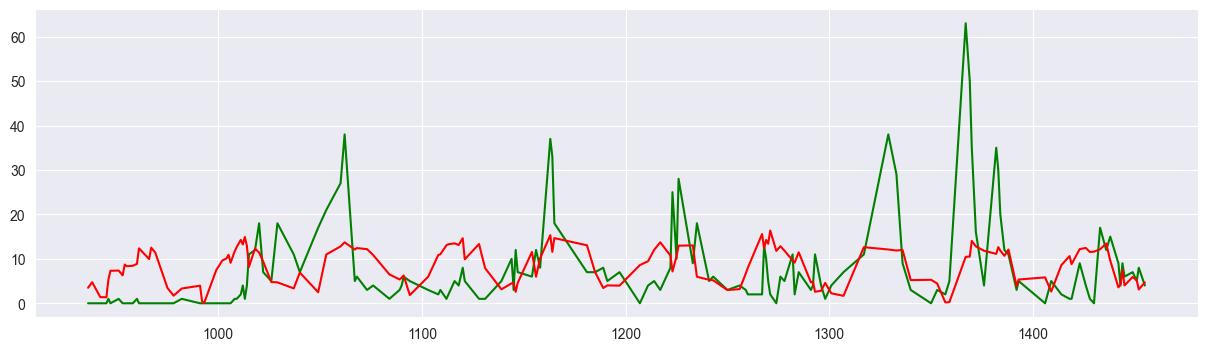

In [69]:
linear_reg_feat_eng_iq = LinearRegression()
linear_reg_feat_eng_iq.fit(iq_x_train, iq_y_train)
y_pred_linear_reg = linear_reg_feat_eng_iq.predict(iq_x_test)
output_with_metrics(linear_reg_feat_eng_iq,iq_x_train,iq_y_train,iq_x_test,iq_y_test,y_pred_linear_reg)

## Random Forest Regression

In [70]:
x = df_iq_phase.drop(['total_cases'], axis=1)
y = df_iq_phase['total_cases']
iq_x_train_rndm, iq_x_test_rndm, iq_y_train_rndm, iq_y_test_rndm = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)

[-7.57106525 -6.10628274 -6.88230402 -5.30691691]
6.5057537984885005
0.10864332974819768


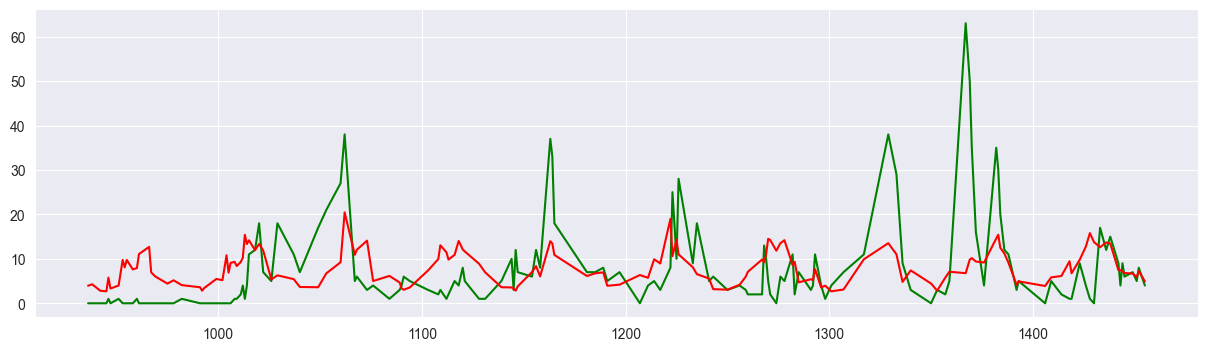

In [71]:
rndm_forest_regr_feat_eng_iq = RandomForestRegressor(max_depth=4, random_state=0)
rndm_forest_regr_feat_eng_iq.fit(iq_x_train_rndm, iq_y_train_rndm)
y_pred_rndm = rndm_forest_regr_feat_eng_iq.predict(iq_x_test_rndm)
output_with_metrics(rndm_forest_regr_feat_eng_iq,iq_x_train_rndm,iq_y_train_rndm,iq_x_test_rndm,iq_y_test_rndm,y_pred_rndm)

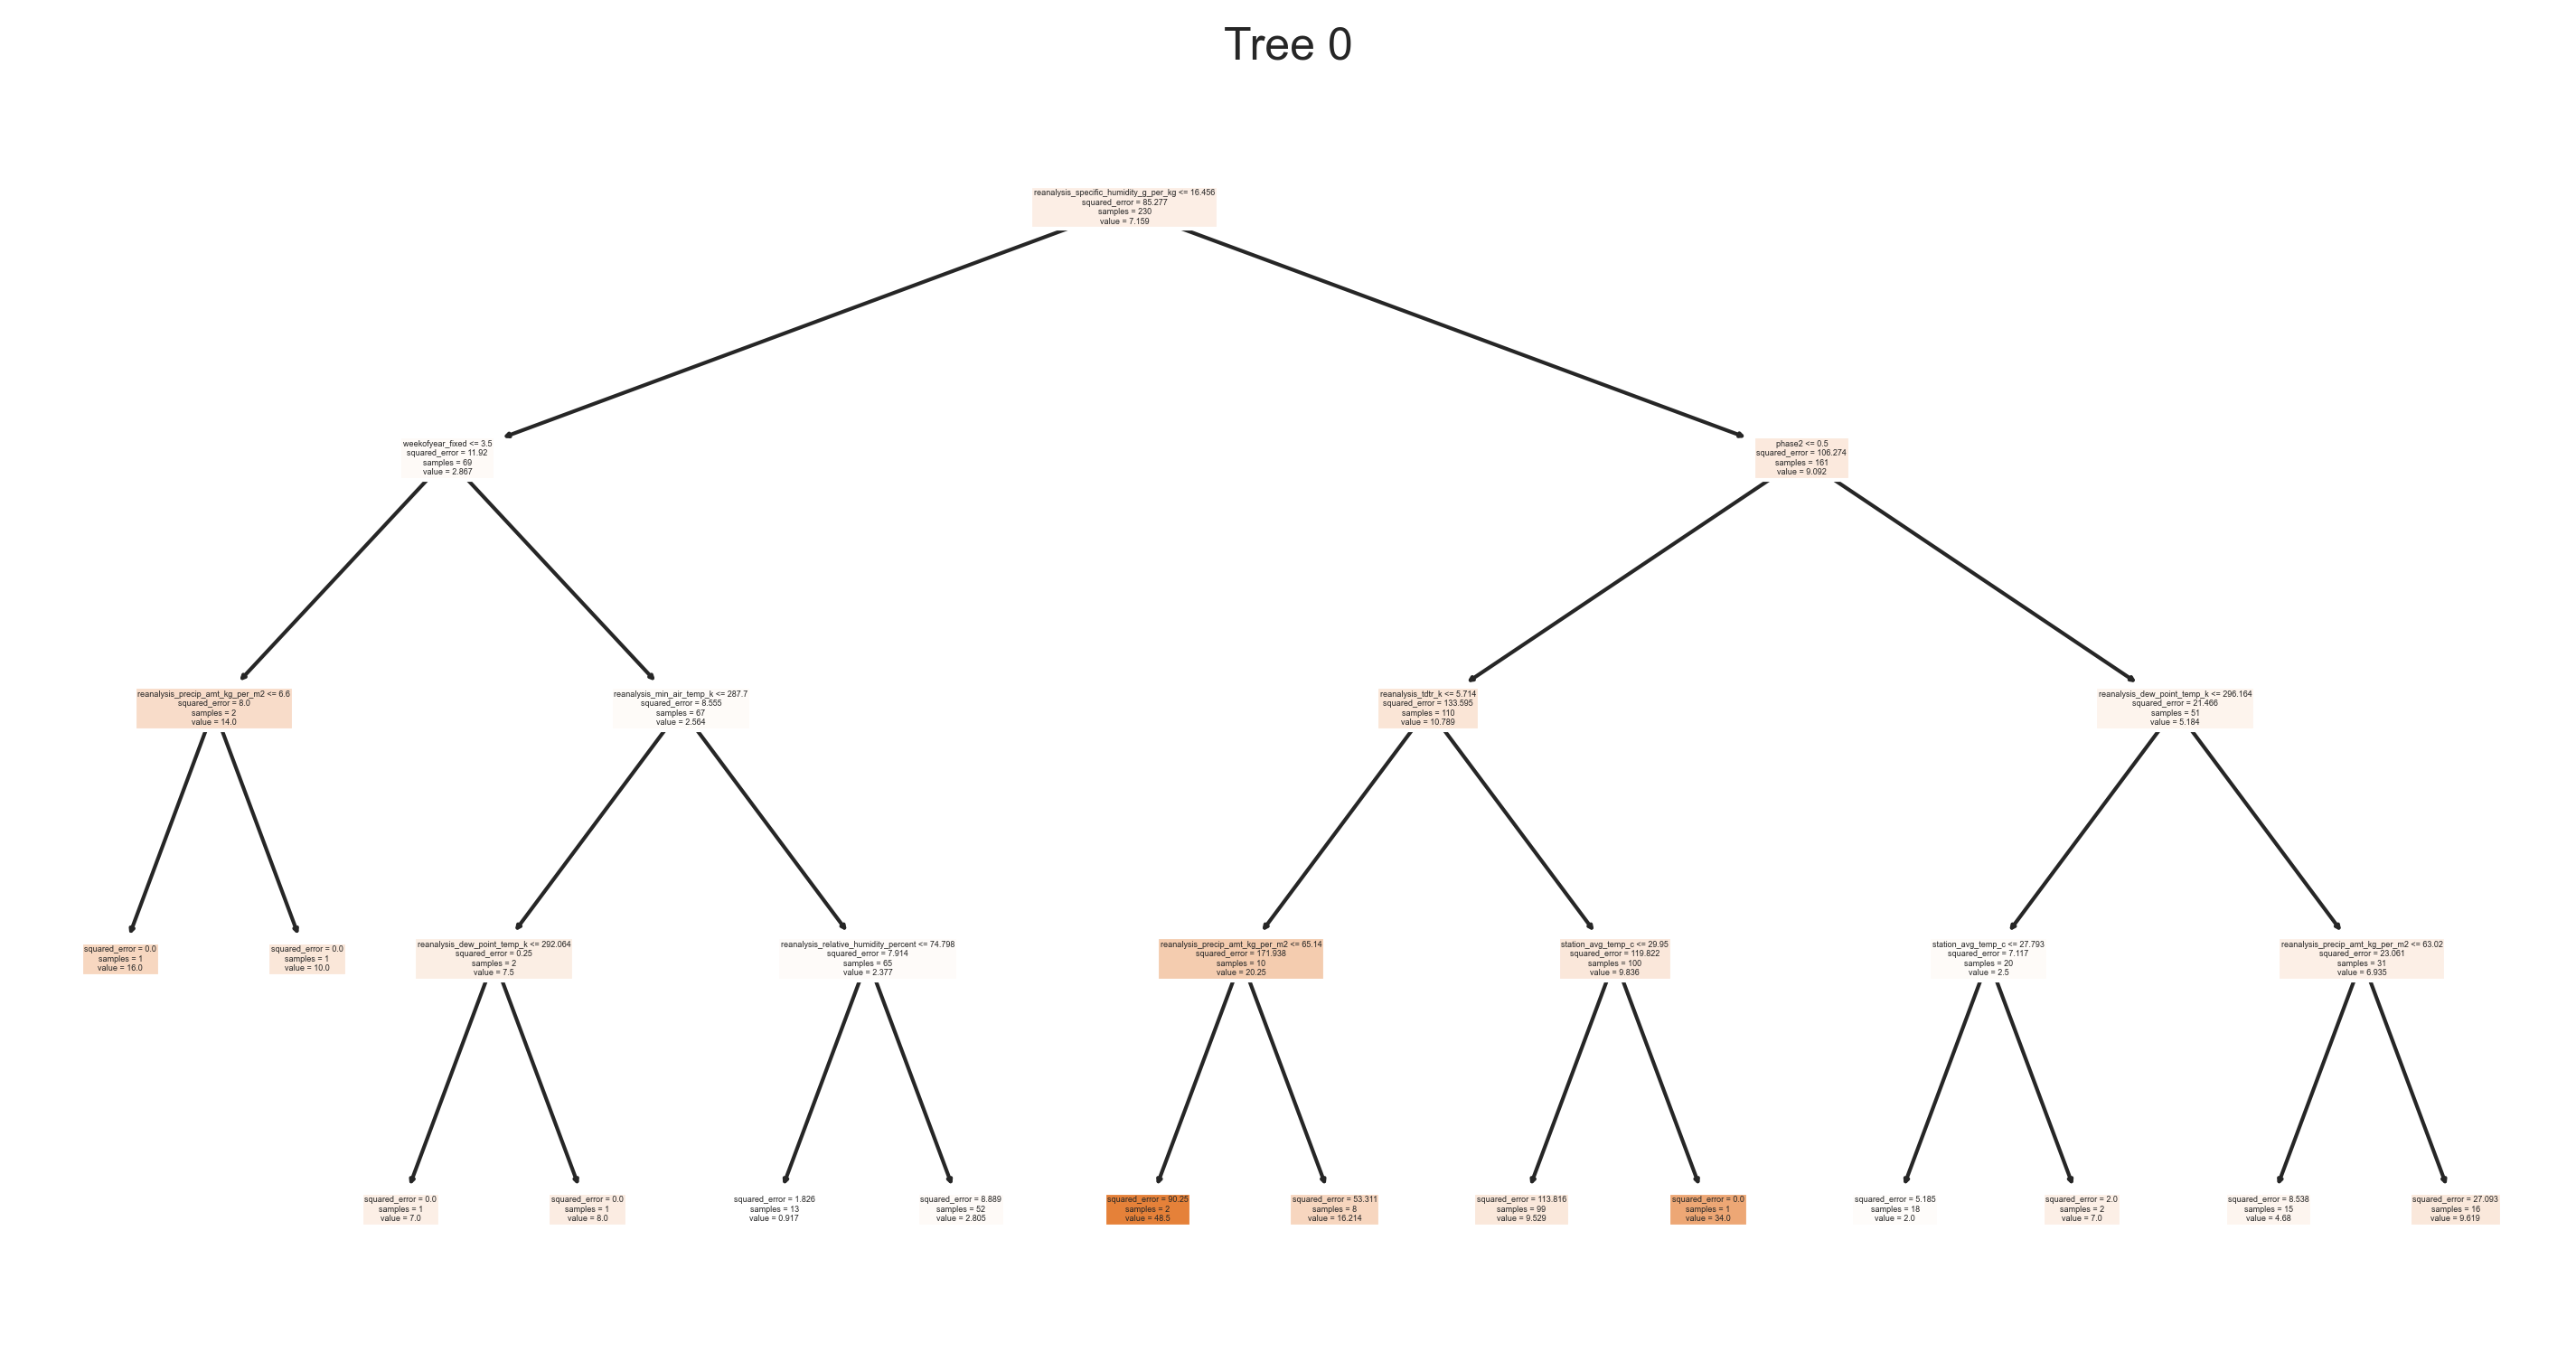

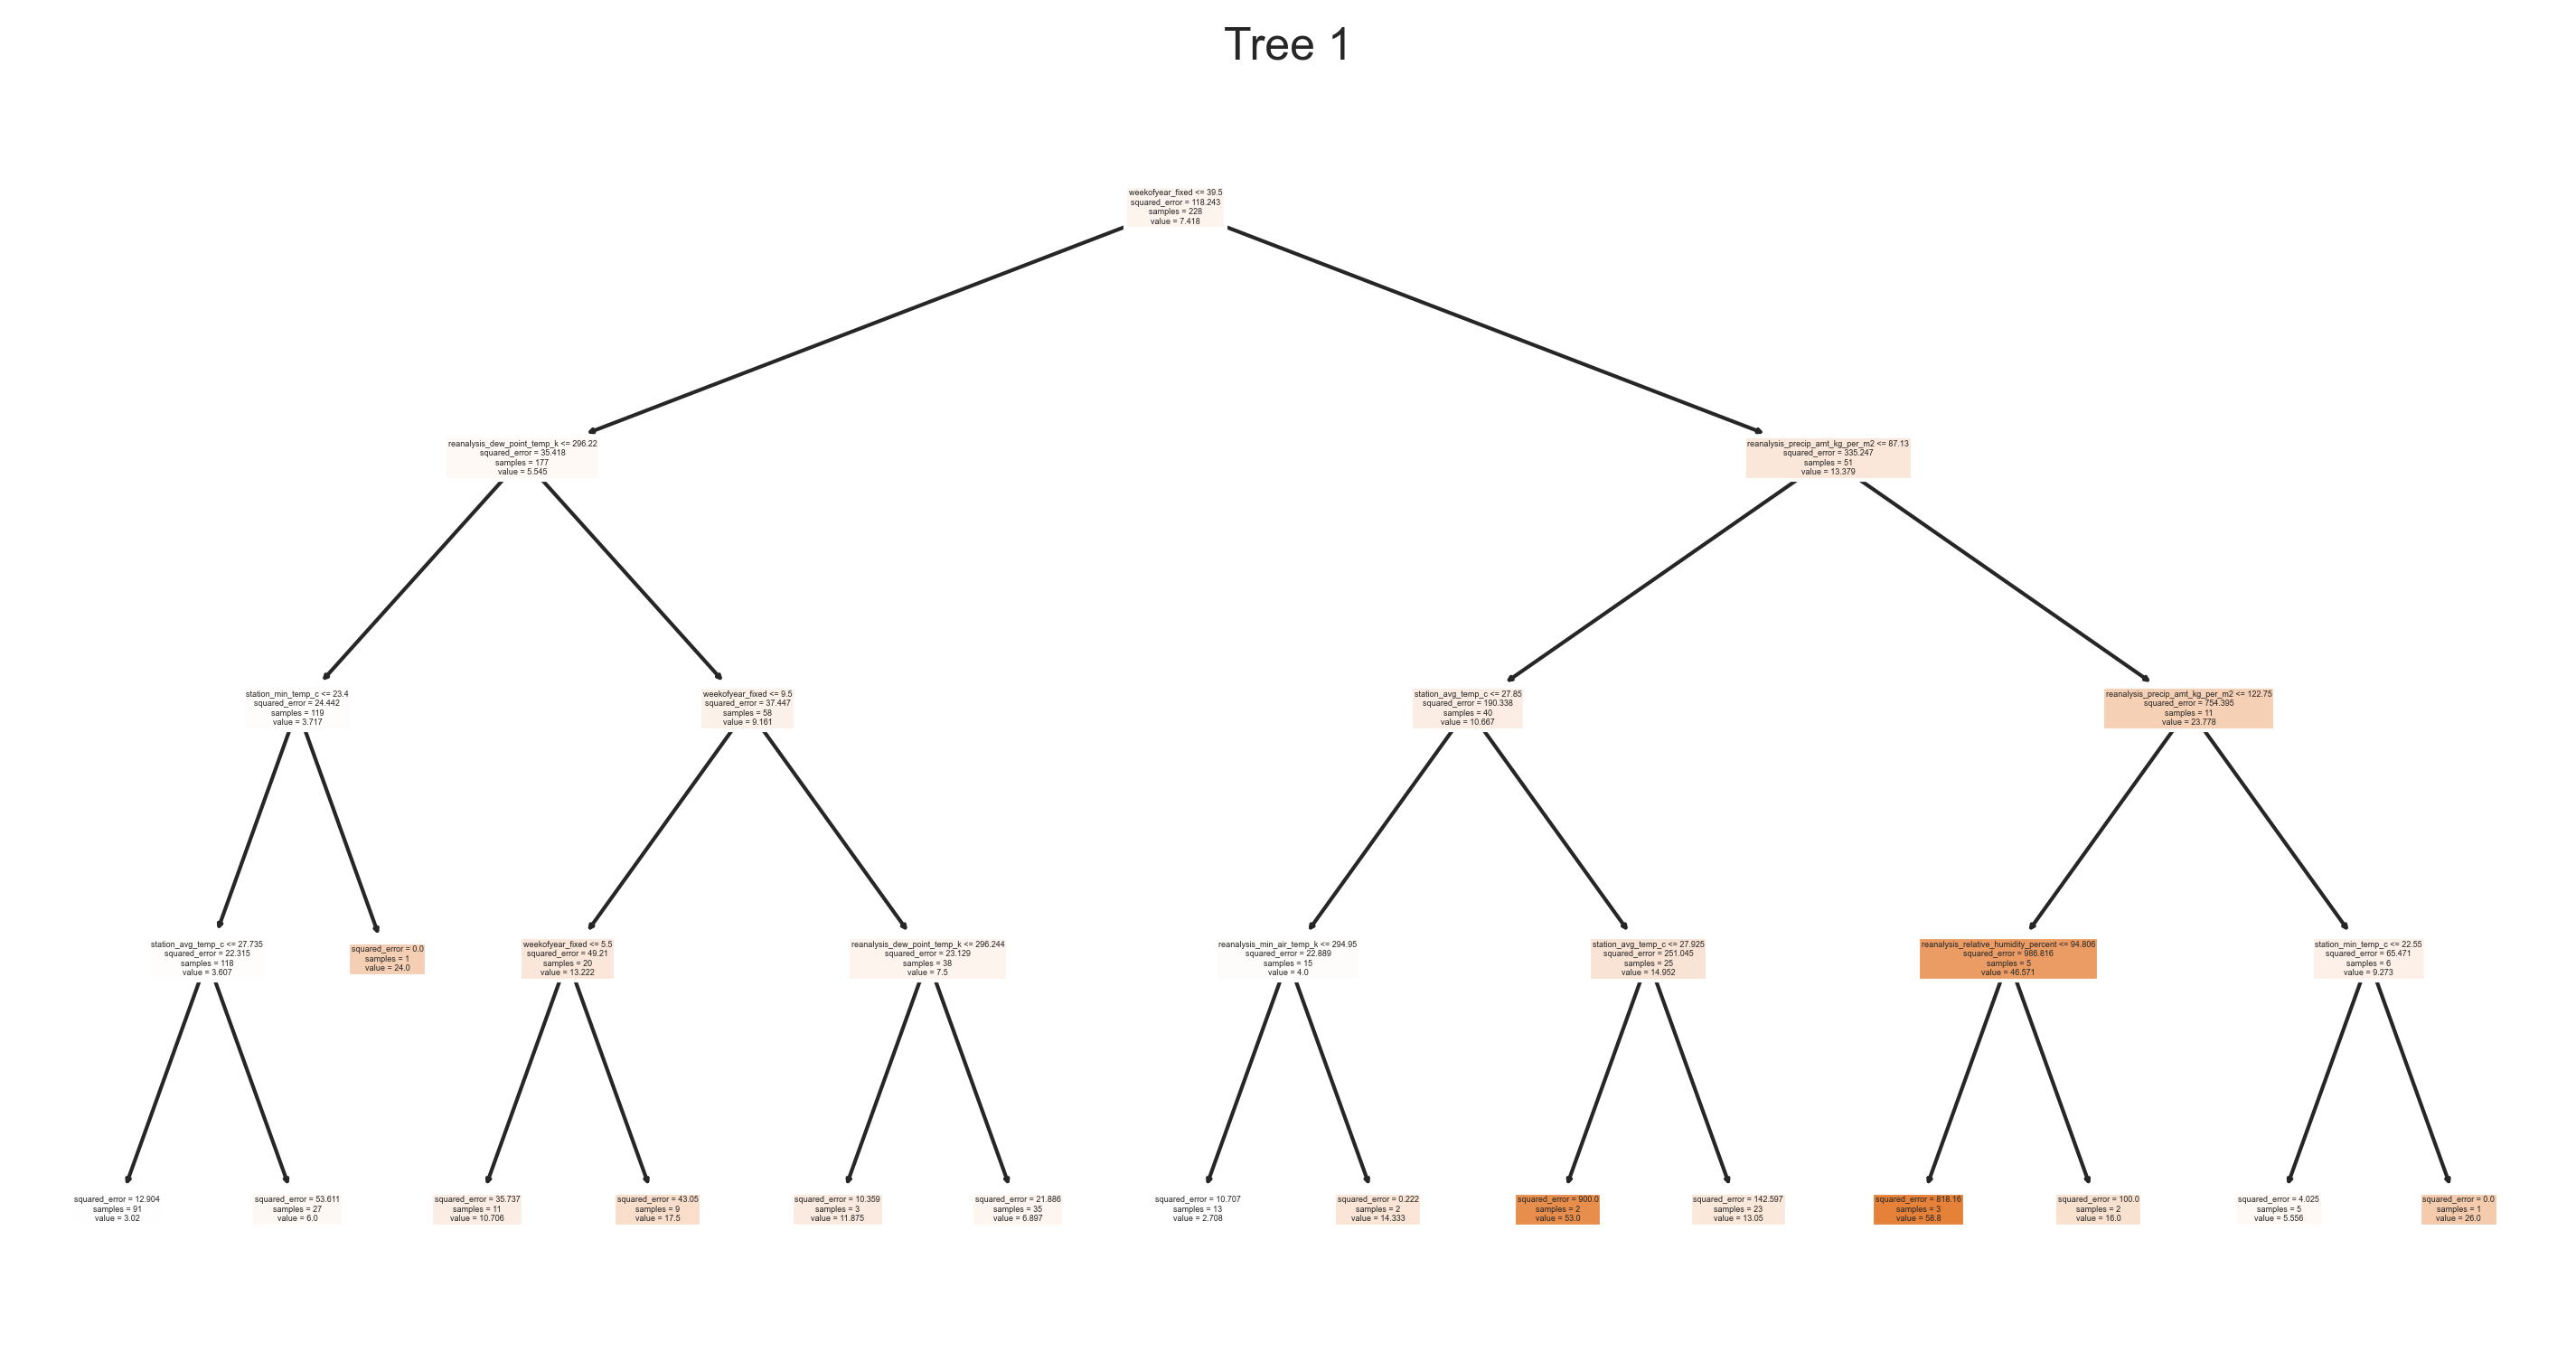

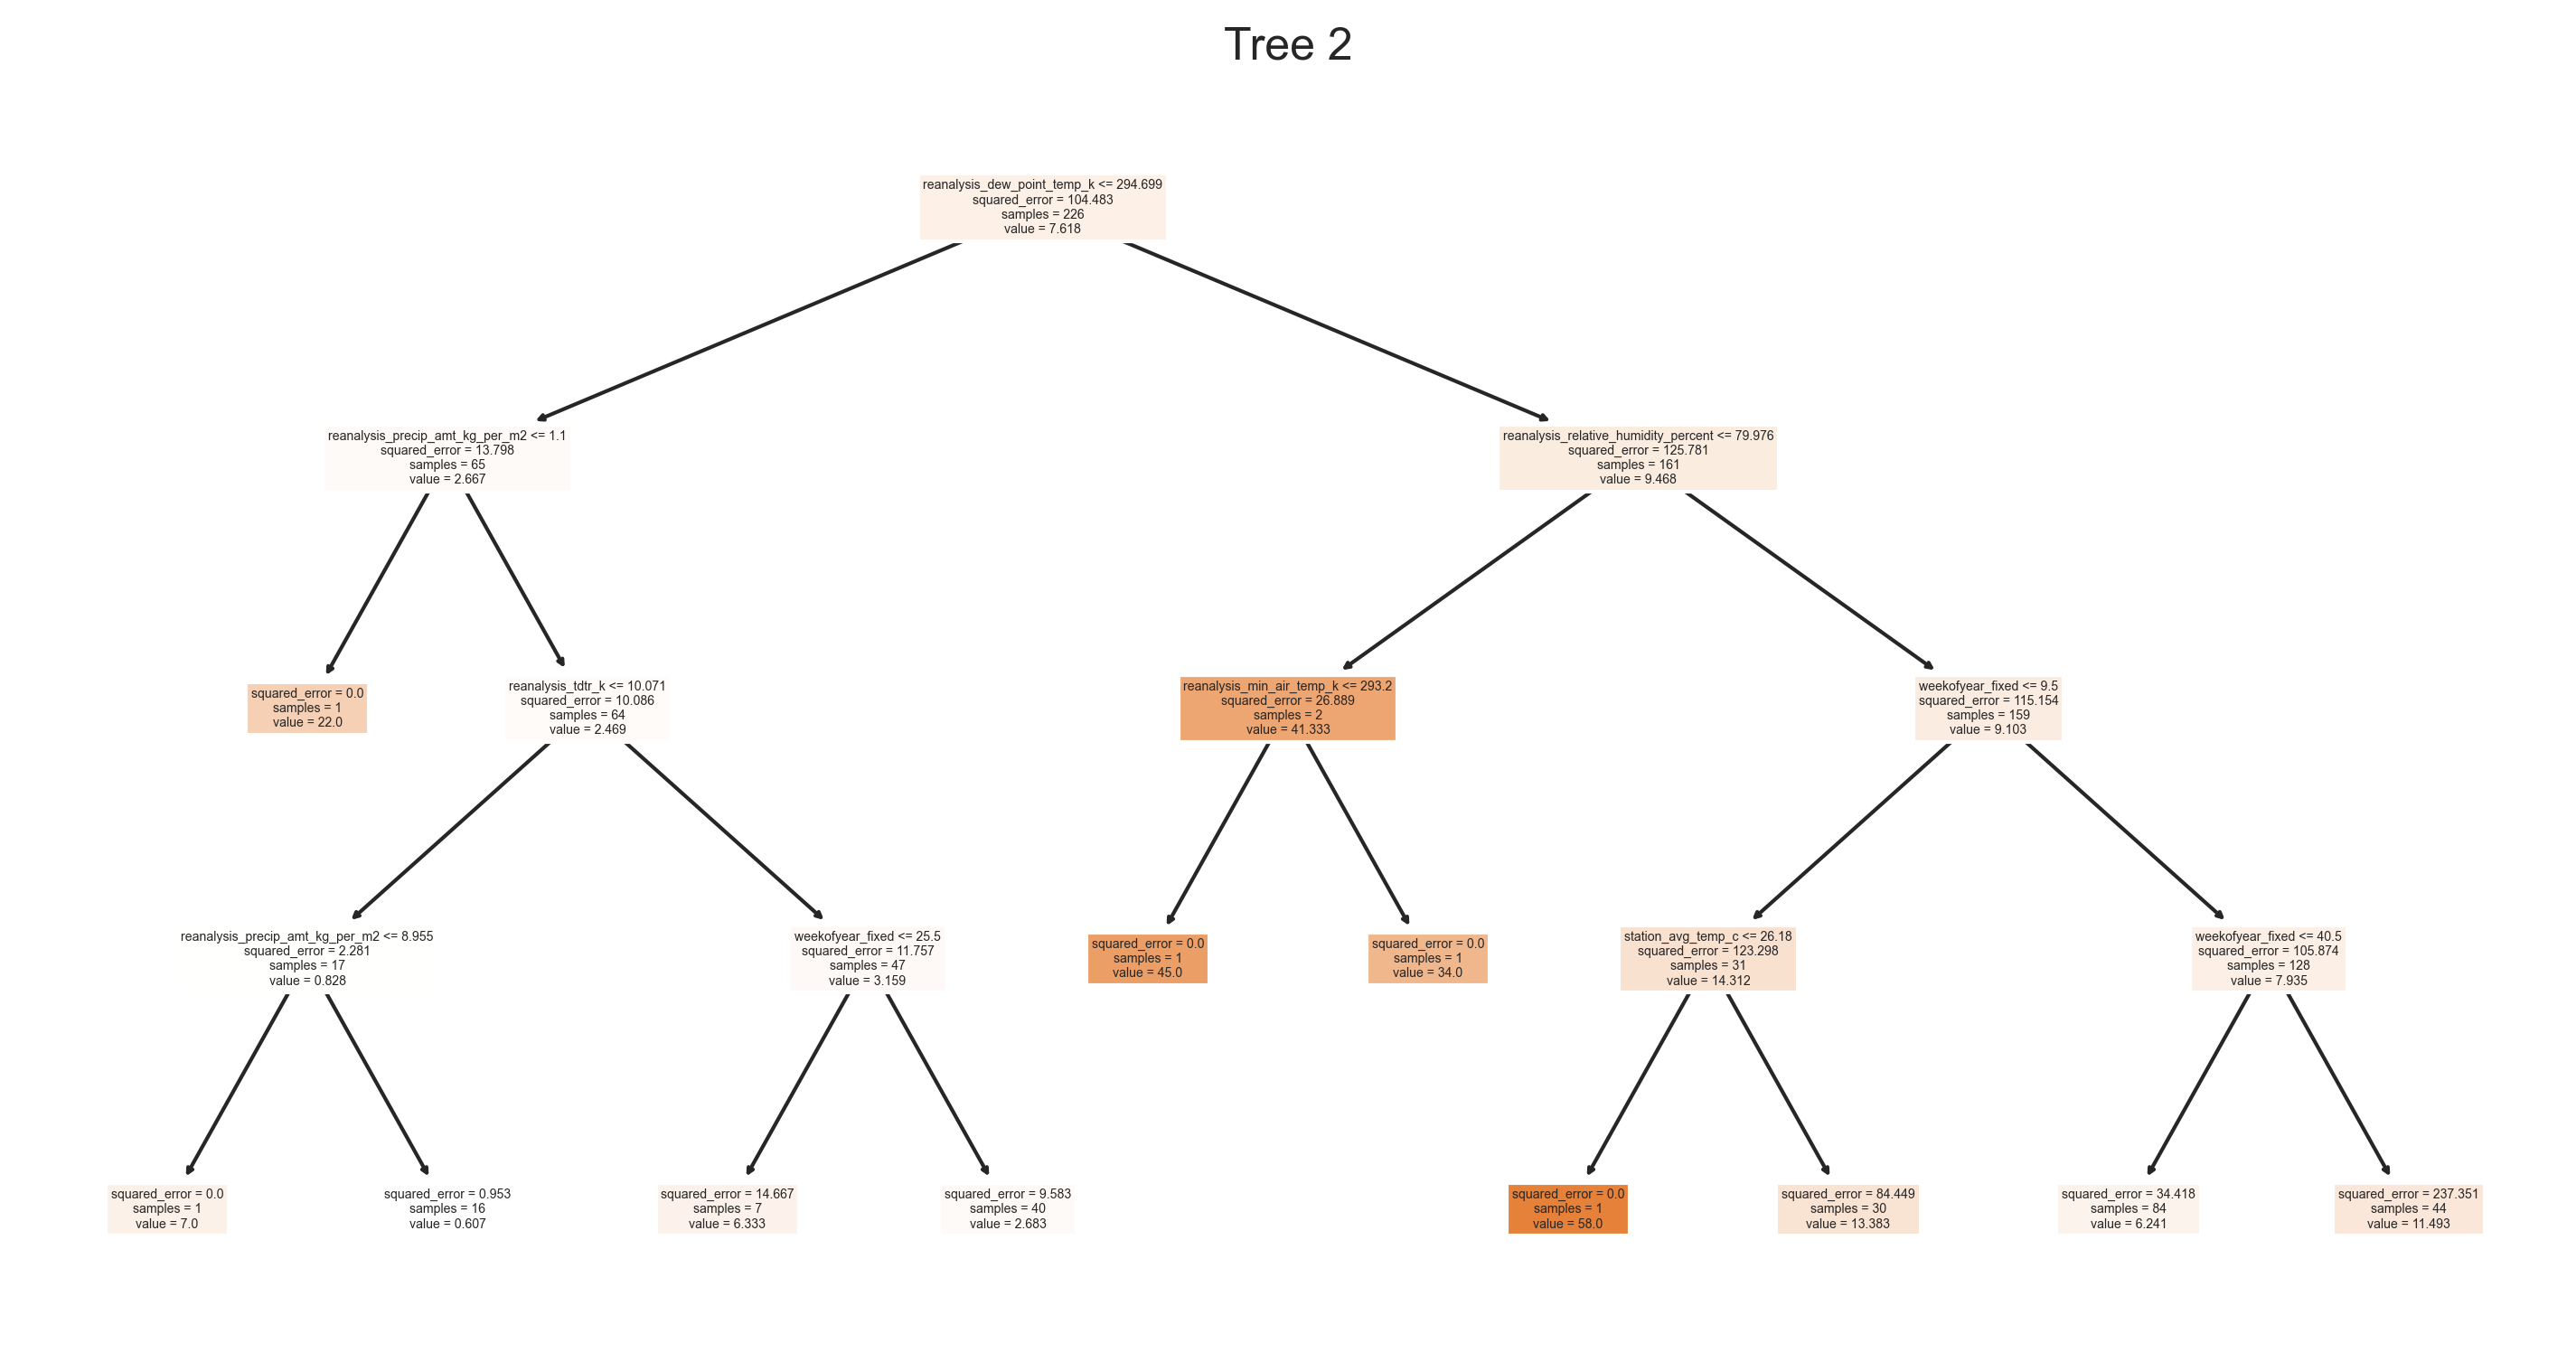

In [72]:
num_trees_to_visualize = 3
for i in range(min(num_trees_to_visualize, len(rndm_forest_regr_feat_eng_iq.estimators_))):
    plt.figure(figsize=(12, 6), dpi=300)  # Increase DPI for higher resolution
    plot_tree(rndm_forest_regr_feat_eng_iq.estimators_[i], feature_names=iq_x_train_rndm.columns, filled=True)
    plt.title(f"Tree {i}")
    plt.savefig(f'tree_{i}.png', dpi=300)  # Save the tree as an image with higher resolution
    plt.show()


## Feature Importance
Die Feature Importance wurde schon durch Verwendung des Korrelationsindexes durchgeführt. Da die ausgewählten Variablen den Datensatz nicht gut beschreiben wird nun eine Feature Importance über alle Variablen mithilfe von Random Forest durchgeführt. Das Ziel ist es, die für die Vorhersage wichtigen Features zu ermitteln.

In [73]:
df_all_features_iq = df_iq_train.copy()
df_all_features_iq.drop(columns=["weekofyear_fixed", "total_cases", "year", "city", "week_start_date"],
                     inplace=True)
df_all_features_iq = df_all_features_iq.interpolate(method='linear', limit_direction='both', limit=26)
df_all_features_iq['phase2'] = df_iq_phase['phase2'].copy()
df_all_features_iq['phase3'] = df_iq_phase['phase3'].copy()
df_all_features_iq['phase4'] = df_iq_phase['phase4'].copy()
df_all_features_iq['phase1'] = 0
df_all_features_iq.loc[(df_all_features_iq['phase2'] == 0) & (df_all_features_iq['phase3'] == 0) & (df_all_features_iq['phase4'] == 0), 'phase1'] = 1

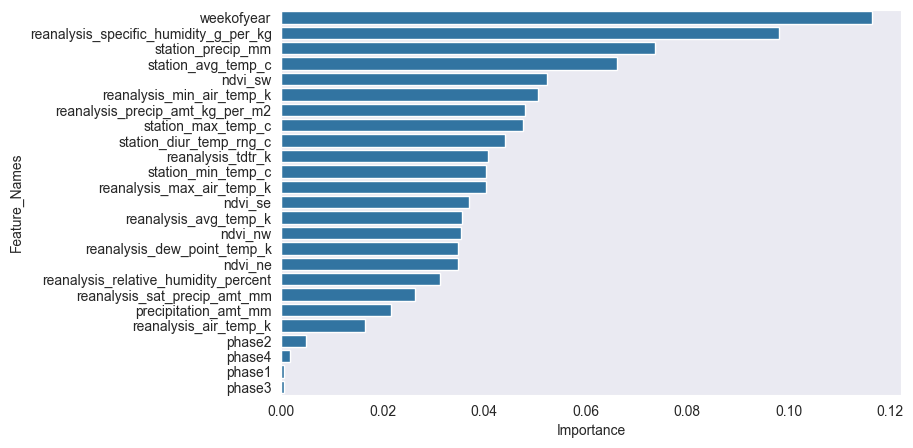

In [74]:
X = df_all_features_iq
y = df_iq_labels['total_cases']
names = df_all_features_iq.columns.values.tolist()

rf_classifier = RandomForestRegressor()
rf_classifier.fit(X, y)
importance = {
    'Feature_Names': names,
    'Importance': rf_classifier.feature_importances_
}
feature_importance = pd.DataFrame(importance)
plt.figure(figsize=(8, 5))
plt.grid()
sns.barplot(x="Importance", y="Feature_Names", data=feature_importance.sort_values(by="Importance", ascending=False))
selected_features_iq = feature_importance[feature_importance['Importance'] >= 0.05]
selected_feature_names_iq = selected_features_iq['Feature_Names'].tolist()

In [75]:
x = df_all_features_iq[selected_feature_names_iq]
y = df_iq_model_features['total_cases']
iq_x_train_feat_imp, iq_x_test_feat_imp, iq_y_train_feat_imp, iq_y_test_feat_imp = train_test_split(x, y, test_size=0.3,
                                                                                    random_state=42)

[-7.48241644 -5.79599027 -6.99849388 -5.64871713]
6.780546963264965
0.03763913953124931


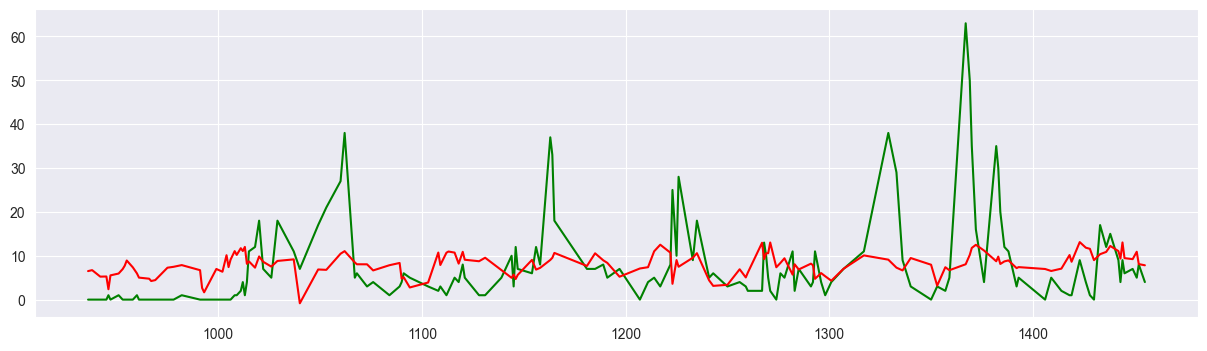

In [76]:
linear_reg_feat_imp_iq = LinearRegression()
linear_reg_feat_imp_iq.fit(iq_x_train_feat_imp, iq_y_train_feat_imp)
y_pred_linear_reg = linear_reg_feat_imp_iq.predict(iq_x_test_feat_imp)
print(cross_val_score(linear_reg_feat_imp_iq, iq_x_train_feat_imp, iq_y_train_feat_imp, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_feat_imp, y_pred_linear_reg, multioutput='uniform_average'))
print(linear_reg_feat_imp_iq.score(iq_x_test_feat_imp, iq_y_test_feat_imp))
examine(y_pred_linear_reg, iq_y_test_feat_imp)

[-6.73274725 -5.47043956 -6.73967033 -4.73192308]
5.949358974358974
0.04002088217244004


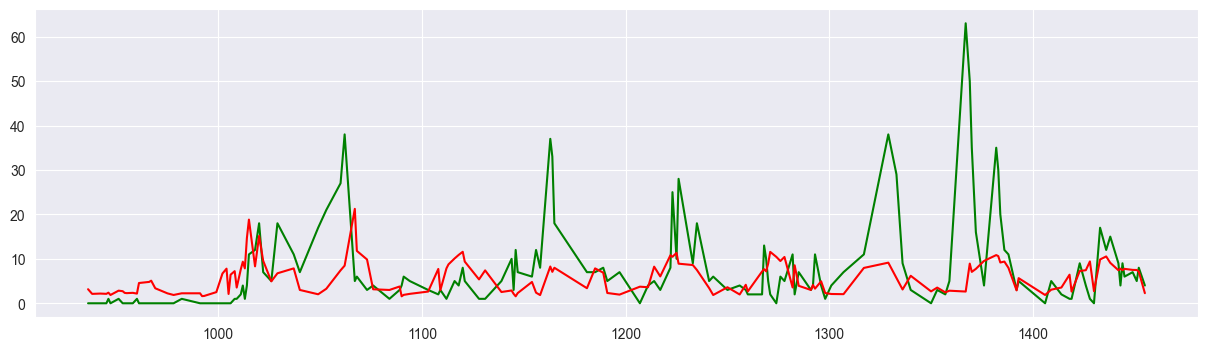

In [77]:
rndm_forest_regr_feat_imp_iq = RandomForestRegressor(criterion="absolute_error",max_depth=4)
rndm_forest_regr_feat_imp_iq.fit(iq_x_train_feat_imp, iq_y_train_feat_imp)
y_pred_rndm = rndm_forest_regr_feat_imp_iq.predict(iq_x_test_feat_imp)
print(cross_val_score(rndm_forest_regr_feat_imp_iq, iq_x_train_feat_imp, iq_y_train_feat_imp, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_feat_imp, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_feat_imp_iq.score(iq_x_test_feat_imp, iq_y_test_feat_imp))
examine(y_pred_rndm, iq_y_test_feat_imp)

## Hyperparameter Tuning

In [78]:
'''
ndm_forest_regr_feat_eng_iq = RandomForestRegressor(criterion="absolute_error", random_state=0,min_samples_split=130)
rndm_forest_regr_feat_eng_iq.fit(iq_x_train_rndm, iq_y_train_rndm)
y_pred_rndm = rndm_forest_regr_feat_eng_iq.predict(iq_x_test_rndm)
print(cross_val_score(rndm_forest_regr_feat_eng_iq, iq_x_train_rndm, iq_y_train_rndm, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_rndm, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_feat_eng_iq.score(iq_x_test_rndm, iq_y_test_rndm))
examine(y_pred_rndm, iq_y_test_rndm)'''


'\nndm_forest_regr_feat_eng_iq = RandomForestRegressor(criterion="absolute_error", random_state=0,min_samples_split=130)\nrndm_forest_regr_feat_eng_iq.fit(iq_x_train_rndm, iq_y_train_rndm)\ny_pred_rndm = rndm_forest_regr_feat_eng_iq.predict(iq_x_test_rndm)\nprint(cross_val_score(rndm_forest_regr_feat_eng_iq, iq_x_train_rndm, iq_y_train_rndm, scoring=\'neg_mean_absolute_error\', cv=4))\nprint(mean_absolute_error(iq_y_test_rndm, y_pred_rndm, multioutput=\'uniform_average\'))\nprint(rndm_forest_regr_feat_eng_iq.score(iq_x_test_rndm, iq_y_test_rndm))\nexamine(y_pred_rndm, iq_y_test_rndm)'

In [79]:
'''rndm_forest_regr_feat_imp_iq = RandomForestRegressor(criterion="absolute_error", random_state=0,min_samples_split=130)
rndm_forest_regr_feat_imp_iq.fit(iq_x_train_feat_imp, iq_y_train_feat_imp)
y_pred_rndm = rndm_forest_regr_feat_imp_iq.predict(iq_x_test_feat_imp)
print(cross_val_score(rndm_forest_regr_feat_imp_iq, iq_x_train_feat_imp, iq_y_train_feat_imp, scoring='neg_mean_absolute_error', cv=4))
print(mean_absolute_error(iq_y_test_feat_imp, y_pred_rndm, multioutput='uniform_average'))
print(rndm_forest_regr_feat_imp_iq.score(iq_x_test_feat_imp, iq_y_test_feat_imp))
examine(y_pred_rndm, iq_y_test_feat_imp)'''

'rndm_forest_regr_feat_imp_iq = RandomForestRegressor(criterion="absolute_error", random_state=0,min_samples_split=130)\nrndm_forest_regr_feat_imp_iq.fit(iq_x_train_feat_imp, iq_y_train_feat_imp)\ny_pred_rndm = rndm_forest_regr_feat_imp_iq.predict(iq_x_test_feat_imp)\nprint(cross_val_score(rndm_forest_regr_feat_imp_iq, iq_x_train_feat_imp, iq_y_train_feat_imp, scoring=\'neg_mean_absolute_error\', cv=4))\nprint(mean_absolute_error(iq_y_test_feat_imp, y_pred_rndm, multioutput=\'uniform_average\'))\nprint(rndm_forest_regr_feat_imp_iq.score(iq_x_test_feat_imp, iq_y_test_feat_imp))\nexamine(y_pred_rndm, iq_y_test_feat_imp)'

In [81]:
'''param_range = np.arange(1, 400)

# Berechnung der Trainings- und Validierungskurven
train_scores, valid_scores = validation_curve(
    RandomForestRegressor(criterion="absolute_error", random_state=0, bootstrap=True),
    iq_x_train_rndm, iq_y_train_rndm, param_name="min_samples_split", param_range=param_range,
    scoring="neg_mean_absolute_error", cv=4
)

# Berechnung der Durchschnittswerte und Standardabweichungen für die Trainings- und Validierungskurven
train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training mean')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation mean')
plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Absolute Error')
plt.title('Validation Curve')
plt.legend(loc='upper right')
plt.show()'''

'param_range = np.arange(1, 400)\n\n# Berechnung der Trainings- und Validierungskurven\ntrain_scores, valid_scores = validation_curve(\n    RandomForestRegressor(criterion="absolute_error", random_state=0, bootstrap=True),\n    iq_x_train_rndm, iq_y_train_rndm, param_name="min_samples_split", param_range=param_range,\n    scoring="neg_mean_absolute_error", cv=4\n)\n\n# Berechnung der Durchschnittswerte und Standardabweichungen für die Trainings- und Validierungskurven\ntrain_mean = -np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\nvalid_mean = -np.mean(valid_scores, axis=1)\nvalid_std = np.std(valid_scores, axis=1)\nplt.figure(figsize=(10, 6))\nplt.plot(param_range, train_mean, color=\'blue\', marker=\'o\', markersize=5, label=\'Training mean\')\nplt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color=\'blue\')\nplt.plot(param_range, valid_mean, color=\'green\', linestyle=\'--\', marker=\'s\', markersize=5, label=\'Validat

In [82]:
'''param_range = np.arange(1, 400)

train_scores, valid_scores = validation_curve(
    RandomForestRegressor(criterion="absolute_error", random_state=0),
    iq_x_train_feat_imp, iq_y_train_feat_imp, param_name="min_samples_split", param_range=param_range,
    scoring="neg_mean_absolute_error", cv=4
)

train_mean = -np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
valid_mean = -np.mean(valid_scores, axis=1)
valid_std = np.std(valid_scores, axis=1)
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, color='blue', marker='o', markersize=5, label='Training mean')
plt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(param_range, valid_mean, color='green', linestyle='--', marker='s', markersize=5, label='Validation mean')
plt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color='green')
plt.xlabel('min_samples_leaf')
plt.ylabel('Mean Absolute Error')
plt.title('Validation Curve')
plt.legend(loc='upper right')
plt.show()'''

'param_range = np.arange(1, 400)\n\ntrain_scores, valid_scores = validation_curve(\n    RandomForestRegressor(criterion="absolute_error", random_state=0),\n    iq_x_train_feat_imp, iq_y_train_feat_imp, param_name="min_samples_split", param_range=param_range,\n    scoring="neg_mean_absolute_error", cv=4\n)\n\ntrain_mean = -np.mean(train_scores, axis=1)\ntrain_std = np.std(train_scores, axis=1)\nvalid_mean = -np.mean(valid_scores, axis=1)\nvalid_std = np.std(valid_scores, axis=1)\nplt.figure(figsize=(10, 6))\nplt.plot(param_range, train_mean, color=\'blue\', marker=\'o\', markersize=5, label=\'Training mean\')\nplt.fill_between(param_range, train_mean + train_std, train_mean - train_std, alpha=0.15, color=\'blue\')\nplt.plot(param_range, valid_mean, color=\'green\', linestyle=\'--\', marker=\'s\', markersize=5, label=\'Validation mean\')\nplt.fill_between(param_range, valid_mean + valid_std, valid_mean - valid_std, alpha=0.15, color=\'green\')\nplt.xlabel(\'min_samples_leaf\')\nplt.ylabe

# Ergebnis

Am besten abgeschnitten hat das Random Forest Regression Model mit Feature Importance, aber da es Risiken bezüglich Overfit gibt, ist die Random Forest Regression mit konstruierten Variablen (Phasen) besser. 

# Vorhersage der Testdaten
Nun werden die Testdaten aus der Datei aus DrivenData vorhergesagt

In [83]:
def preprocess_sj(df_train):
    # Choose Feature Columns
    df_feat = df_train[['station_max_temp_c','reanalysis_relative_humidity_percent','reanalysis_precip_amt_kg_per_m2']].copy()
    #Normalize Columns
    temp_cols = ['reanalysis_air_temp_k',
                           'reanalysis_avg_temp_k',
                           'reanalysis_max_air_temp_k',
                           'station_avg_temp_c',
                           'reanalysis_min_air_temp_k',
                           'station_min_temp_c',
                           'reanalysis_dew_point_temp_k']
    humid_cols = ['reanalysis_specific_humidity_g_per_kg']
    normalize_cols(df_train,df_feat,temp_cols,'temp_avg')
    normalize_cols(df_train,df_feat,humid_cols,'norm_humid_amount')
    scaler = MinMaxScaler()
    norm_atts = ['station_max_temp_c', 'reanalysis_relative_humidity_percent', 'reanalysis_precip_amt_kg_per_m2']
    df_feat[norm_atts] = scaler.fit_transform(df_feat[norm_atts])
    # Fix Week-Problem
    df_train.loc[:,'weekofyear_fixed'] = np.where(df_train.year==2010,
                                              df_train.weekofyear+1, df_train.weekofyear) 
    for year in [2011,2012]:
        df_train.loc[:,'weekofyear_fixed'] = np.where(df_train.year==year,
                                                      df_train.weekofyear_fixed+1, df_train.weekofyear_fixed)
    df_train.loc[:,'weekofyear'] = np.where(df_train.weekofyear_fixed>52,
                                            1, df_train.weekofyear_fixed)
    df_feat['weekofyear_fixed'] = df_train['weekofyear_fixed'].copy()
    # Interpolate Missing Data
    df_feat = df_feat.interpolate(method='pad')
    # Phase
    for index, row in df_train.iterrows():
        phase = 0
        if 0 <= row['weekofyear_fixed'] <= 11:
            phase = 1
        elif 12 <= row['weekofyear_fixed'] <= 22:
            phase = 2
        elif 23 <= row['weekofyear_fixed'] <= 52:
            phase = 3
        df_feat.loc[index, 'phase1'] = 1 if phase == 1 else 0
        df_feat.loc[index, 'phase2'] = 1 if phase == 2 else 0
        df_feat.loc[index, 'phase3'] = 1 if phase == 3 else 0
    df_feat.drop(columns=['phase1'],inplace=True)
    return df_feat

In [84]:
def preprocess_iq(df_train):
    # Choose Feature Columns
    df_feat = df_train[['reanalysis_dew_point_temp_k', 'reanalysis_min_air_temp_k',
       'station_min_temp_c', 'reanalysis_tdtr_k',
       'reanalysis_specific_humidity_g_per_kg',
       'reanalysis_relative_humidity_percent',
       'reanalysis_precip_amt_kg_per_m2', 'station_avg_temp_c']].copy()
    # Wochen müssen nicht angepasst werden, da im Testdatensatz Iquitos keine Woche 53 vorkommt
    df_feat['weekofyear_fixed'] = df_train['weekofyear'].astype(int).copy()
    # Interpolate Missing Data
    df_feat = df_feat.interpolate(method='pad')
    # Phase
    for index, row in df_train.iterrows():
        phase = 0
        if 0 <= row['weekofyear'] <= 12:
            phase = 1
        elif 13 <= row['weekofyear'] <= 24:
            phase = 2
        elif 25 <= row['weekofyear'] <= 36:
            phase = 3
        elif 37 <= row['weekofyear'] <= 52:
            phase = 4

        df_feat.loc[index, 'phase1'] = 1 if phase == 1 else 0
        df_feat.loc[index, 'phase2'] = 1 if phase == 2 else 0
        df_feat.loc[index, 'phase3'] = 1 if phase == 3 else 0
        df_feat.loc[index, 'phase4'] = 1 if phase == 4 else 0
    df_feat[['phase1', 'phase2', 'phase3', 'phase4']] = df_feat[['phase1', 'phase2', 'phase3', 'phase4']].astype(int)
    return df_feat

In [85]:
df_test = pd.read_csv("dataset/dengue_features_test.csv")

In [86]:
df_sj_test = df_test.loc[df_test['city']=='sj']
df_iq_test = df_test.loc[df_test['city']=='iq']

In [87]:
#df_iq_preprocess = preprocess_iq(df_iq_test)

In [88]:
for index, row in df_sj_test.iterrows():
        phase = 0
        if 23 <= row['weekofyear']:
            phase = 3
        df_sj_test.loc[index, 'phase3'] = 1 if phase == 3 else 0

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\1947992890.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_test.loc[index, 'phase3'] = 1 if phase == 3 else 0


In [89]:
df_time = df_sj_test[["year","weekofyear"]].copy()

In [90]:
df_sj_test.drop(columns=["city","year","week_start_date"],inplace=True)

C:\Users\rener\AppData\Local\Temp\ipykernel_25824\3353528992.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sj_test.drop(columns=["city","year","week_start_date"],inplace=True)


In [91]:
df_sj_test = df_sj_test.interpolate(method='linear', limit_direction='both', limit=26)

In [92]:
df_sj_preprocess = df_sj_test[selected_feature_names]

KeyError: "['weekofyear_fixed'] not in index"

In [ ]:
y_pred_rndm_forest_regr_sj = pd.DataFrame()

In [ ]:
y_pred_rndm_forest_regr_iq = df_iq_test[['year', 'weekofyear']].copy()

In [ ]:
y_pred_rndm_forest_regr_sj['total_cases'] = rndm_forest_regr_feat_imp_sj.predict(df_sj_preprocess)

In [ ]:
df_iq_test = df_iq_test.interpolate(method='linear', limit_direction='both', limit=26)

In [ ]:
df_iq_preprocess = df_iq_test[selected_feature_names_iq]

In [ ]:
y_pred_rndm_forest_regr_iq['total_cases'] = rndm_forest_regr_feat_imp_iq.predict(df_iq_preprocess)

In [ ]:
y_pred_rndm_forest_regr_sj = pd.concat([df_time[['year', 'weekofyear']], y_pred_rndm_forest_regr_sj], axis=1)

In [ ]:
y_pred_rndm_forest_regr_sj['city'] = 'sj'
y_pred_rndm_forest_regr_iq['city'] = 'iq'

df_both_predicted_rndm = pd.concat([y_pred_rndm_forest_regr_sj, y_pred_rndm_forest_regr_iq], ignore_index=True)
df_both_predicted_rndm = df_both_predicted_rndm[['city'] + [col for col in df_both_predicted_rndm.columns if col != 'city']]

In [ ]:
df_both_predicted_rndm['total_cases'] = df_both_predicted_rndm['total_cases'].round()
df_both_predicted_rndm['total_cases'] = df_both_predicted_rndm['total_cases'].astype(int)

In [ ]:
# Die Wochen der Jahre 2010-2012 von sj müssen um 1 subtrahiert werden
#for year in [2010,2011,2012]:
#    df_both_predicted_rndm.loc[(df_both_predicted_rndm['city'] == "sj") & (df_both_predicted_rndm['year'] == year), 'weekofyear'] -= 1

In [ ]:
#df_both_predicted_rndm.loc[(df_both_predicted_rndm['weekofyear']==0) & (df_both_predicted_rndm['year'] == 2010), #'weekofyear'] = 53

#df_both_predicted_rndm.loc[(df_both_predicted_rndm['weekofyear']==0) & (df_both_predicted_rndm['year'] != 2010), #'weekofyear'] = 52

In [ ]:
df_both_predicted_rndm

In [ ]:
df_both_predicted_rndm.to_csv('result.csv', index=False)